In [1]:
from mesh import *

from VPINN_tri_final import *

from PROBDEF import PROBDEF


tfk=tf.keras
tfkl=tf.keras.layers

2023-11-30 15:35:57.721361: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-30 15:35:57.729469: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-30 15:35:57.803569: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-30 15:35:57.804104: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-30 15:35:58.650714: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co


my_types lib imported

generate mesh lib imported

interpolator_lib imported

settings_lib imported 



### MESH

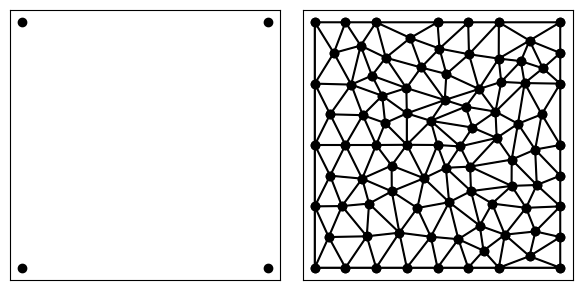

In [2]:
#seed for reproducibility 
initializer=tf.keras.initializers.GlorotUniform(seed=54)


#mesh init 
domain=((0,0),(1,0),(1,1),(0,1))
mesh=generate_mesh(domain,0.01)



### BC_NET

In [3]:
#net used for approximating the fully dirichlet bc  
bc_model = tfk.models.Sequential()
bc_model.add(tf.keras.Input(shape=(2,),dtype=tf_type))
bc_model.add(tfkl.Dense(10, activation='tanh',kernel_initializer=initializer,dtype=tf_type,bias_initializer=initializer))
bc_model.add(tfkl.Dense(10, activation='tanh',kernel_initializer=initializer,dtype=tf_type,bias_initializer=initializer))
bc_model.add(tfkl.Dense(10, activation='tanh',kernel_initializer=initializer,dtype=tf_type,bias_initializer=initializer))
bc_model.add(tfkl.Dense(10, activation='tanh',kernel_initializer=initializer,dtype=tf_type,bias_initializer=initializer))
bc_model.add(tf.keras.layers.Dense(1,activation='linear',kernel_initializer=initializer,dtype=tf_type,use_bias=True))

In [4]:
print(bc_model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                30        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 371 (2.90 KB)
Trainable params: 371 (2.90 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [5]:
#setting model to the current net 
model=bc_model

#helper function to treat the net as a lamda function 
def model_np(x, y):
    eval=tf.constant([[x,y]],dtype=tf.float64)
    return model(eval).numpy()[0,0] 


def model_np_(x, y,model):

    x_=tf.reshape(x,(-1,1))
    y_=tf.reshape(y,(-1,1))

    eval=tf.concat([x_,y_],axis=1)

    return tf.reshape(model(eval),(tf.shape(x)[0],-1))



In [6]:
#order of test function 
N_test = 1

#importing probdef 
pb=PROBDEF()


params = {'scheme': 'VPINNs',
            'domain': ((0.0, 1.0), (0.0, 1.0)),
            'N_test':N_test}

In [7]:
def plot_BC(u_exact,u_NN_BC_):
    """ both numpy functions """
    x=np.linspace(0,1,200,dtype=np.float64)


    eval_exact=[u_exact(x[i],1.0) for i in range(len(x))]

    eval_net=[u_NN_BC_(x[i],1.0) for i in range(len(x))]

    eval_exact=np.array(eval_exact)
    eval_net=np.array(eval_net)

    plt.figure(figsize=(8, 6))  # Set the figure size

    # Plot the data
    plt.plot(x, eval_net, label='eval_net', linestyle='-', marker='o', color='b')
    plt.plot(x, eval_exact, label='eval_exact', linestyle='--', marker='x', color='r')
    plt.grid()
    plt.title('top edge')
    plt.legend()


    eval_exact=[u_exact(x[i],0.0) for i in range(len(x))]

    eval_net=[u_NN_BC_(x[i],0.0) for i in range(len(x))]

    eval_exact=np.array(eval_exact)
    eval_net=np.array(eval_net)

    plt.figure(figsize=(8, 6))  # Set the figure size

    # Plot the data
    plt.plot(x, eval_net, label='eval_net', linestyle='-', marker='o', color='b')
    plt.plot(x, eval_exact, label='eval_exact', linestyle='--', marker='x', color='r')
    plt.grid()
    plt.title('bottom edge')
    plt.legend()


    eval_exact=[u_exact(1.0,x[i]) for i in range(len(x))]

    eval_net=[u_NN_BC_(1.0,x[i]) for i in range(len(x))]

    eval_exact=np.array(eval_exact)
    eval_net=np.array(eval_net)

    plt.figure(figsize=(8, 6))  # Set the figure size

    # Plot the data
    plt.plot(x, eval_net, label='eval_net', linestyle='-', marker='o', color='b')
    plt.plot(x, eval_exact, label='eval_exact', linestyle='--', marker='x', color='r')
    plt.grid()
    plt.title('right edge')
    plt.legend()



    eval_exact=[u_exact(0.0,x[i]) for i in range(len(x))]

    eval_net=[u_NN_BC_(0.0,x[i]) for i in range(len(x))]

    eval_exact=np.array(eval_exact)
    eval_net=np.array(eval_net)

    plt.figure(figsize=(8, 6))  # Set the figure size

    # Plot the data
    plt.plot(x, eval_net, label='eval_net', linestyle='-', marker='o', color='b')
    plt.plot(x, eval_exact, label='eval_exact', linestyle='--', marker='x', color='r')
    plt.grid()
    plt.title('left edge')
    plt.legend()


    eval_exact=[u_exact(x[i],0.5) for i in range(len(x))]

    eval_net=[u_NN_BC_(x[i],0.5) for i in range(len(x))]

    eval_exact=np.array(eval_exact)
    eval_net=np.array(eval_net)

    plt.figure(figsize=(8, 6))  # Set the figure size

    # Plot the data
    plt.plot(x, eval_net, label='eval_net', linestyle='-', marker='o', color='b')
    plt.plot(x, eval_exact, label='eval_exact', linestyle='--', marker='x', color='r')
    plt.grid()
    plt.title('slice in the middle y=0.5')
    plt.legend()


    eval_exact=[u_exact(x[i],0.25) for i in range(len(x))]

    eval_net=[u_NN_BC_(x[i],0.25) for i in range(len(x))]

    eval_exact=np.array(eval_exact)
    eval_net=np.array(eval_net)

    plt.figure(figsize=(8, 6))  # Set the figure size

    # Plot the data
    plt.plot(x, eval_net, label='eval_net', linestyle='-', marker='o', color='b')
    plt.plot(x, eval_exact, label='eval_exact', linestyle='--', marker='x', color='r')
    plt.grid()
    plt.title('slice in the middle y=0.25')
    plt.legend()


    eval_exact=[u_exact(x[i],0.75) for i in range(len(x))]

    eval_net=[u_NN_BC_(x[i],0.75) for i in range(len(x))]

    eval_exact=np.array(eval_exact)
    eval_net=np.array(eval_net)

    plt.figure(figsize=(8, 6))  # Set the figure size

    # Plot the data
    plt.plot(x, eval_net, label='eval_net', linestyle='-', marker='o', color='b')
    plt.plot(x, eval_exact, label='eval_exact', linestyle='--', marker='x', color='r')
    plt.grid()
    plt.title('slice in the middle y=0.75')
    plt.legend()


    eval_exact=[u_exact(0.5,x[i]) for i in range(len(x))]

    eval_net=[u_NN_BC_(0.5,x[i]) for i in range(len(x))]

    eval_exact=np.array(eval_exact)
    eval_net=np.array(eval_net)

    plt.figure(figsize=(8, 6))  # Set the figure size

    # Plot the data
    plt.plot(x, eval_net, label='eval_net', linestyle='-', marker='o', color='b')
    plt.plot(x, eval_exact, label='eval_exact', linestyle='--', marker='x', color='r')
    plt.grid()
    plt.title('slice in the middle x=0.50')
    plt.legend()
    

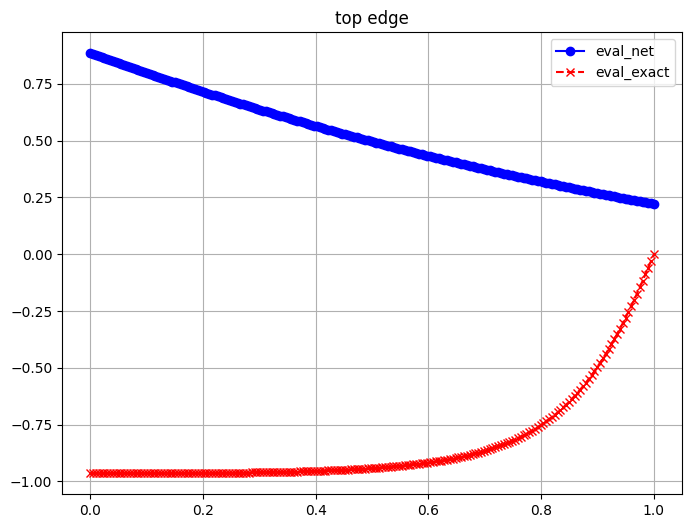

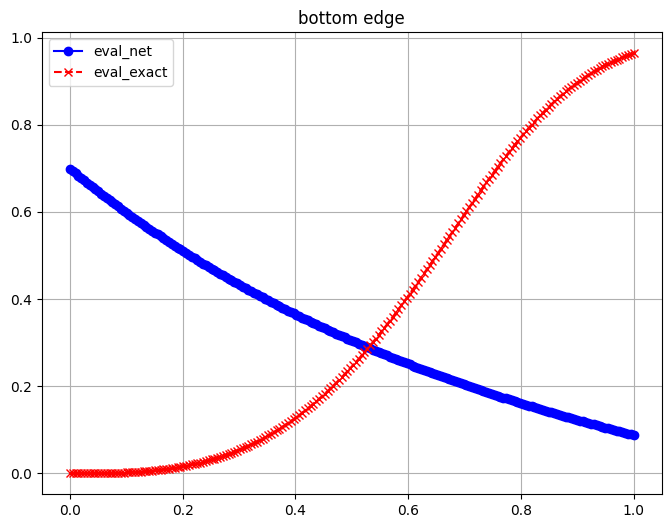

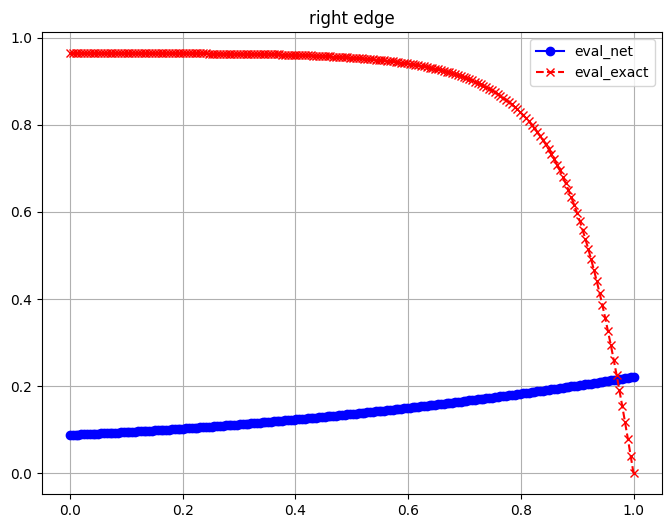

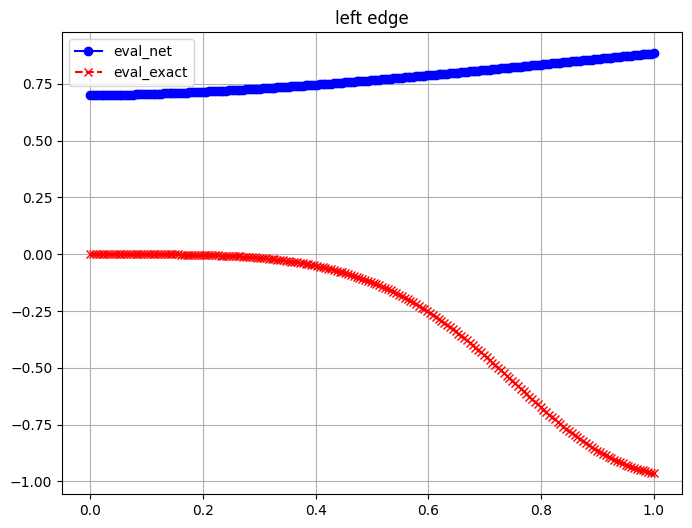

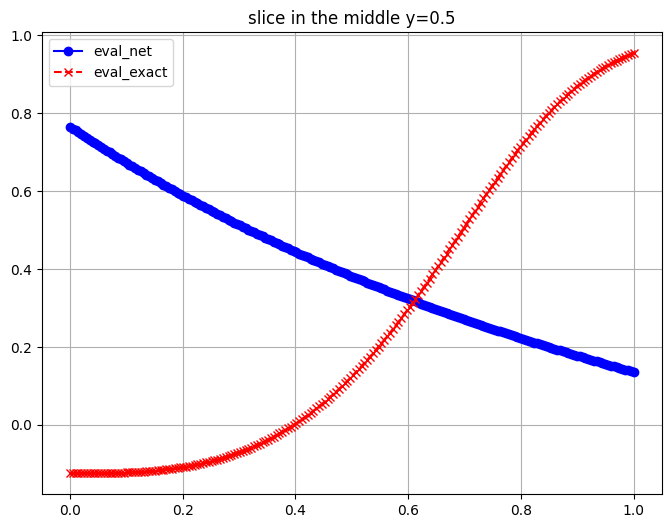

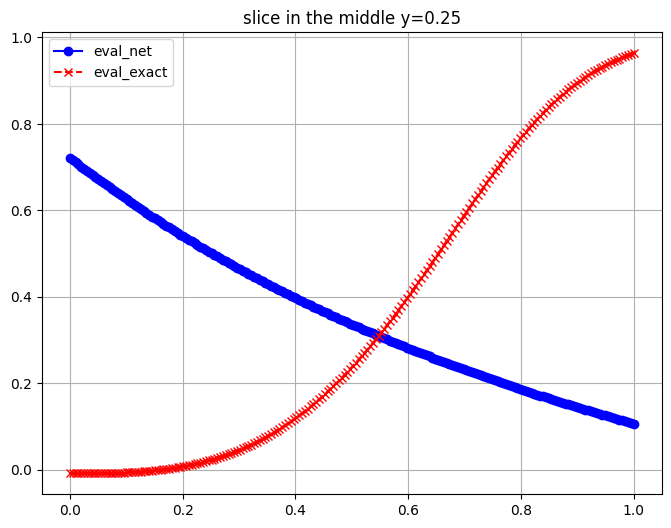

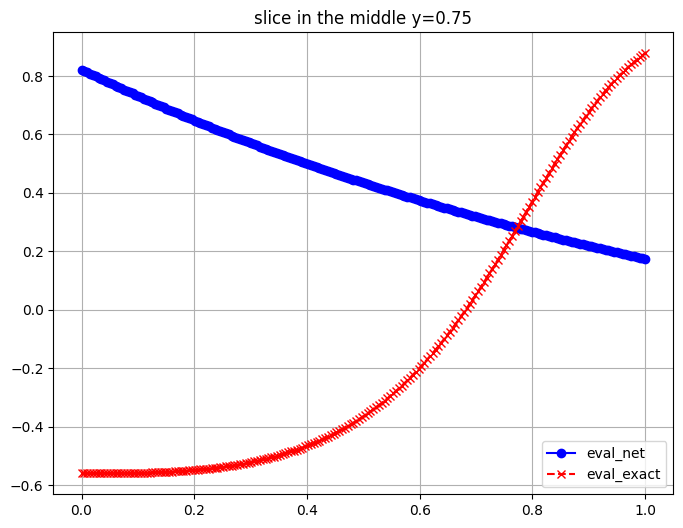

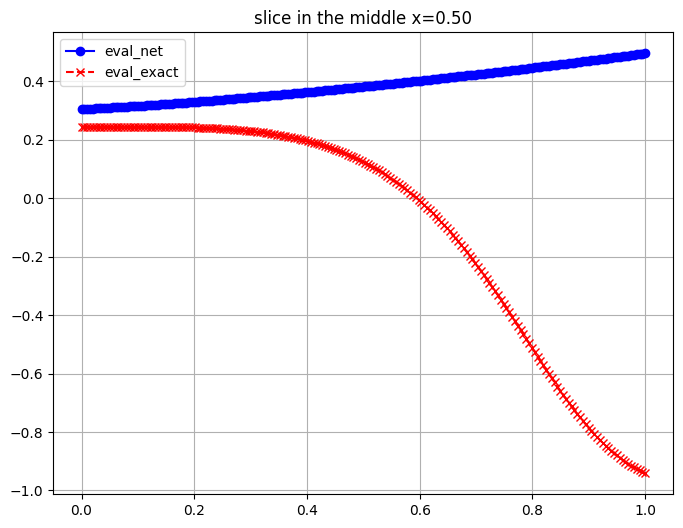

In [8]:
#to compare real solution and the model 
plot_BC(pb.u_exact_np,model_np)

In [9]:


def color_plot(model):
    x = np.linspace(0, 1, 1000)
    y = np.linspace(0, 1, 1000)

    X, Y = np.meshgrid(x, y)


    error = np.abs(pb.u_exact_np(X,Y)-model_np_(X,Y,model))

    fig=plt.imshow(
        error,
        extent=[min(x), max(x), min(y), max(y)],
        vmin=np.min(error),
        vmax=np.max(error)
    )
    plt.title('Error Map')
    plt.colorbar(fig)

    # Show the positions of the sample points, just to have some reference
    fig.axes.set_autoscale_on(False)
    



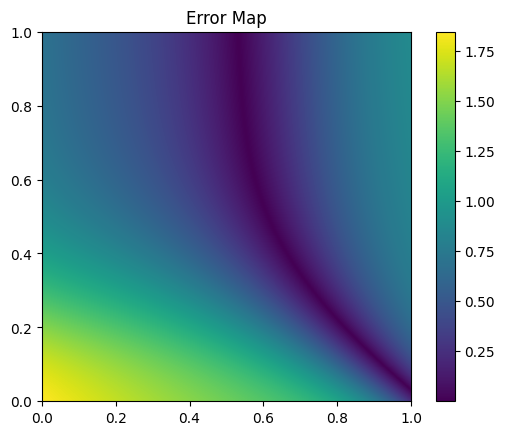

In [10]:
color_plot(model)

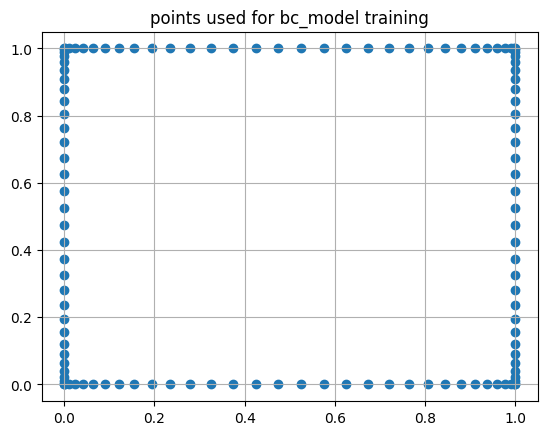

In [11]:
#to learn bc 
x=pb.generate_boundary_points(30,False)
plt.scatter(x[:,0],x[:,1])
plt.title('points used for bc_model training')
plt.grid()

y=pb.u_exact(x[:,0],x[:,1])
y=tf.reshape(y,(-1,1))

In [12]:
#training process of bc_model with the MSE as loss function 
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Adjust the learning rate as needed
bc_model.compile(optimizer=custom_optimizer, loss='mean_squared_error')
history=model.fit(x, y, epochs=3000, batch_size=np.size(y))

Epoch 1/3000
1/1 [==============================] - 1s 610ms/step - loss: 1.0634
Epoch 2/3000
1/1 [==============================] - 0s 3ms/step - loss: 1.0161
Epoch 3/3000
1/1 [==============================] - 0s 2ms/step - loss: 0.9720
Epoch 4/3000
1/1 [==============================] - 0s 4ms/step - loss: 0.9312
Epoch 5/3000
1/1 [==============================] - 0s 3ms/step - loss: 0.8936
Epoch 6/3000
1/1 [==============================] - 0s 3ms/step - loss: 0.8591
Epoch 7/3000
1/1 [==============================] - 0s 2ms/step - loss: 0.8275
Epoch 8/3000
1/1 [==============================] - 0s 2ms/step - loss: 0.7985
Epoch 9/3000
1/1 [==============================] - 0s 5ms/step - loss: 0.7718
Epoch 10/3000
1/1 [==============================] - 0s 3ms/step - loss: 0.7472
Epoch 11/3000
1/1 [==============================] - 0s 3ms/step - loss: 0.7243
Epoch 12/3000
1/1 [==============================] - 0s 2ms/step - loss: 0.7029
Epoch 13/3000
1/1 [============================

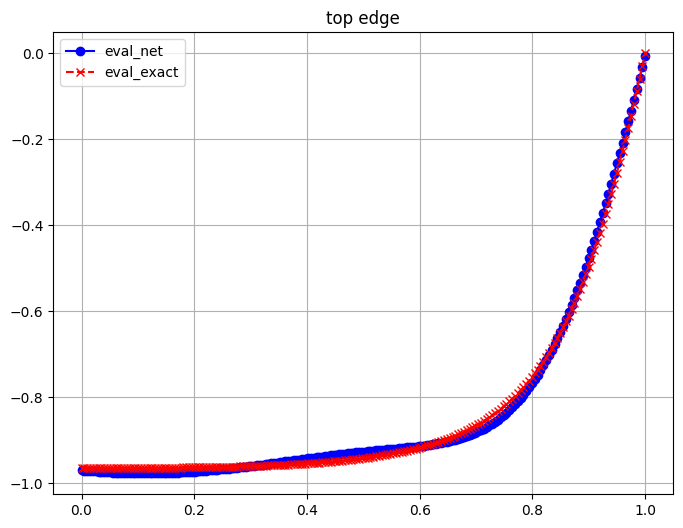

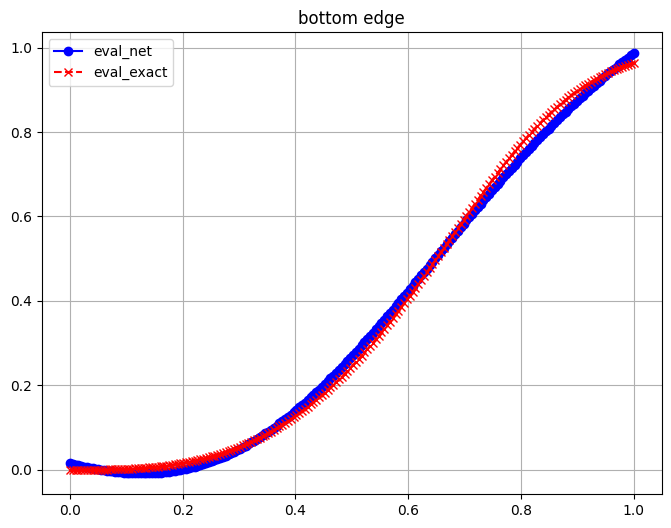

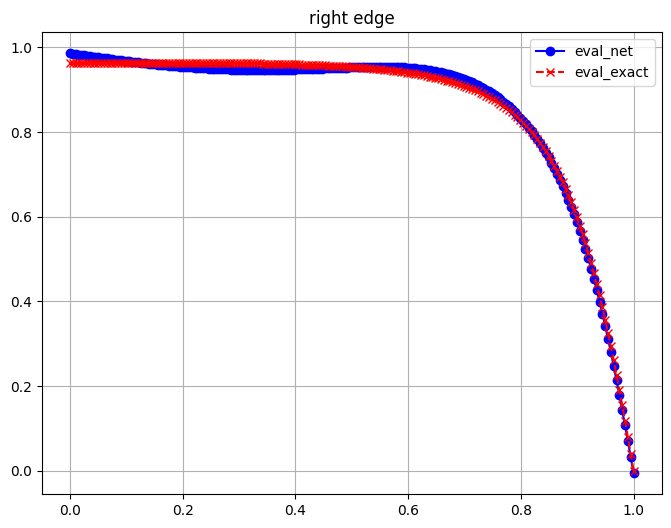

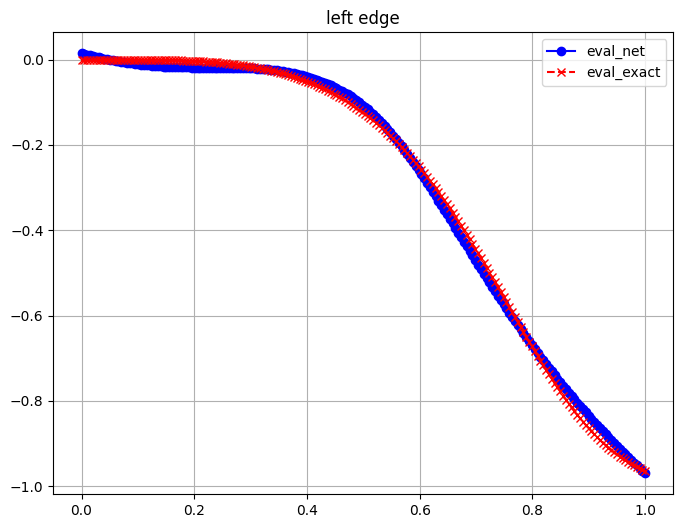

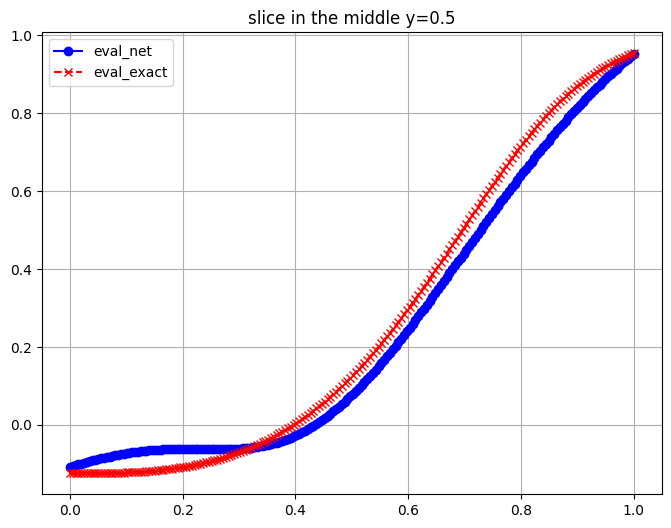

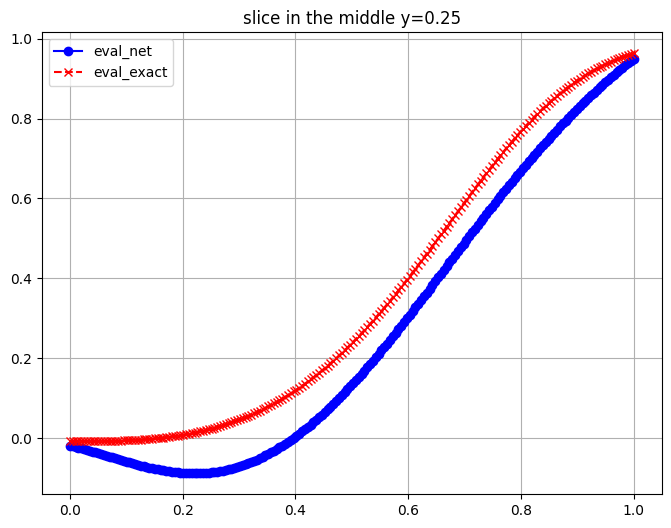

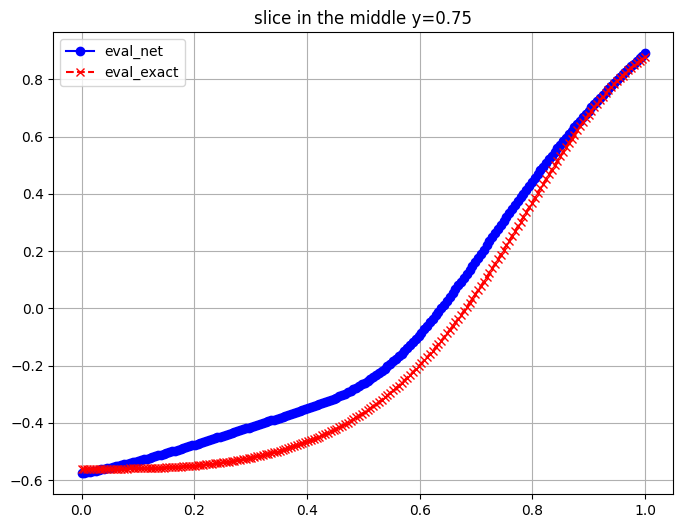

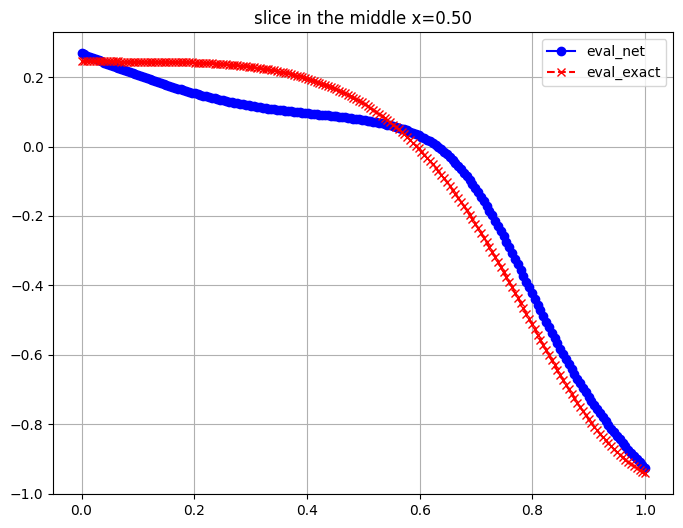

In [13]:
#plt the trained net
plot_BC(pb.u_exact_np,model_np)

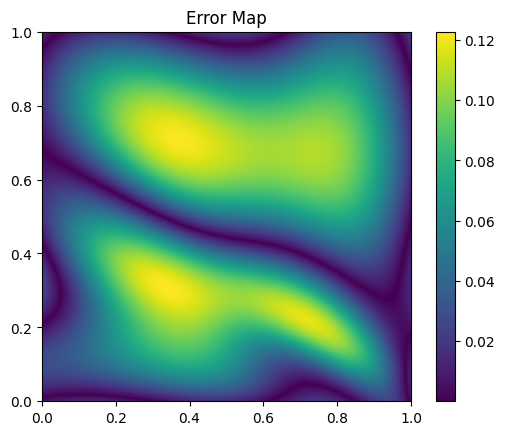

In [14]:
color_plot(model)

In [15]:

#make the bc_model  non trainable 
for layer in bc_model.layers:
    layer.trainable = False

# Display model summary after making weights non-trainable
bc_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                30        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 371 (2.90 KB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 371 (2.90 KB)
_________________________________________________________________


####  REAL MODEL

In [16]:
MODEL = tfk.models.Sequential()
MODEL.add(tf.keras.Input(shape=(2,),dtype=tf_type))
MODEL.add(tfkl.Dense(50, activation='tanh',kernel_initializer=initializer,dtype=tf_type,bias_initializer=initializer))
MODEL.add(tfkl.Dense(50, activation='tanh',kernel_initializer=initializer,dtype=tf_type,bias_initializer=initializer))
MODEL.add(tfkl.Dense(50, activation='tanh',kernel_initializer=initializer,dtype=tf_type,bias_initializer=initializer))
MODEL.add(tf.keras.layers.Dense(1,activation='linear',kernel_initializer=initializer,dtype=tf_type,use_bias=True))

MODEL.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 50)                150       
                                                                 
 dense_6 (Dense)             (None, 50)                2550      
                                                                 
 dense_7 (Dense)             (None, 50)                2550      
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 5301 (41.41 KB)
Trainable params: 5301 (41.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


basis:
basis function number :  1

1 x^0 y^0 -1 x^1 y^0 -1 x^0 y^1 

basis function number :  2

0 x^0 y^0 1 x^1 y^0 0 x^0 y^1 

basis function number :  3

0 x^0 y^0 0 x^1 y^0 1 x^0 y^1 

basis :
d1x
basis function number :  1

-1 x^0 y^0 

d1y
basis function number :  1

-1 x^0 y^0 


d1x
basis function number :  2

1 x^0 y^0 

d1y
basis function number :  2

0 x^0 y^0 


d1x
basis function number :  3

0 x^0 y^0 

d1y
basis function number :  3

1 x^0 y^0 


basis :
d2x
basis function number :  1



d2y
basis function number :  1




d2x
basis function number :  2



d2y
basis function number :  2




d2x
basis function number :  3



d2y
basis function number :  3




degree =  1  , local dof =  3  internal dof =  0  points inside each edge =  0
[[0 0]
 [1 0]
 [0 1]]


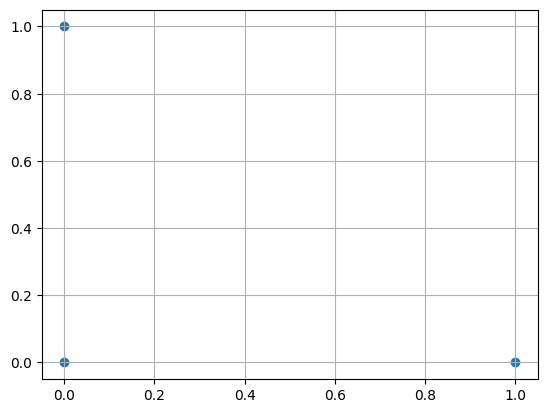

-->mesh : 
     n_triangles :  150
     n_vertices  :  88
     n_edges     :  237
     h_max           :  0.25
     h_min           :  0.0895721626833764
-->test_fun      : 
     order       :  1
     dof         :  64


In [17]:
vp=VPINN(pb,params,mesh,MODEL)
model=vp.u_NN_BC
vp.set_NN_BC(bc_model)

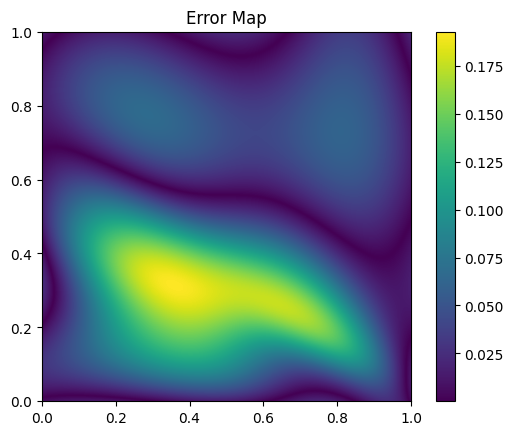

In [18]:
color_plot(vp.NN_imposeBC)

In [19]:
history=vp.train(1000,0.001,bc_model)

Iteration: 0 loss: 0.0176300135 time: 15.947195053100586
Iteration: 10 loss: 0.0154825810 time: 0.45892953872680664
Iteration: 20 loss: 0.0135446423 time: 0.4566020965576172
Iteration: 30 loss: 0.0114998234 time: 0.44268202781677246
Iteration: 40 loss: 0.0101170267 time: 0.44821929931640625
Iteration: 50 loss: 0.0099834590 time: 0.45415520668029785
Iteration: 60 loss: 0.0098150582 time: 0.4447457790374756
Iteration: 70 loss: 0.0096029362 time: 0.44460535049438477
Iteration: 80 loss: 0.0093389035 time: 0.45072007179260254
Iteration: 90 loss: 0.0088905807 time: 0.45380091667175293
Iteration: 100 loss: 0.0081454870 time: 0.46300816535949707
Iteration: 110 loss: 0.0070717310 time: 0.46640896797180176
Iteration: 120 loss: 0.0060471194 time: 0.468660831451416
Iteration: 130 loss: 0.0056030433 time: 0.5165588855743408
Iteration: 140 loss: 0.0054594138 time: 0.4957270622253418
Iteration: 150 loss: 0.0053319687 time: 0.4709949493408203
Iteration: 160 loss: 0.0052577448 time: 0.5045840740203857


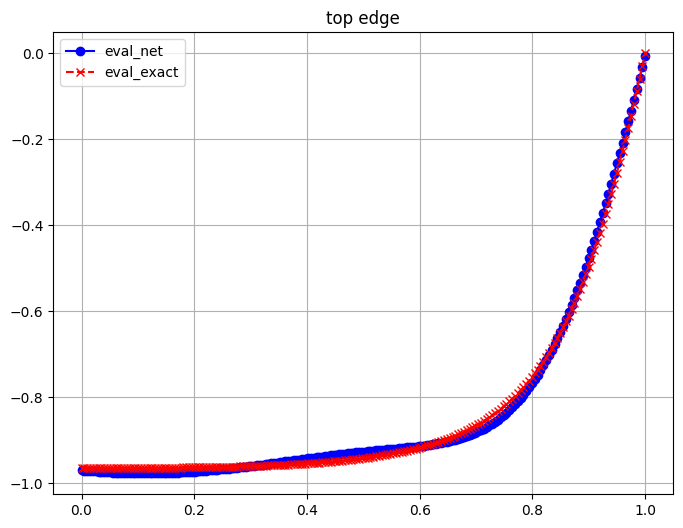

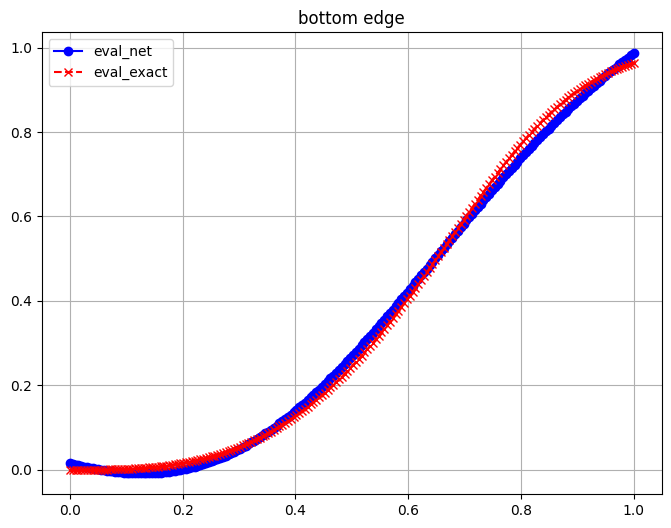

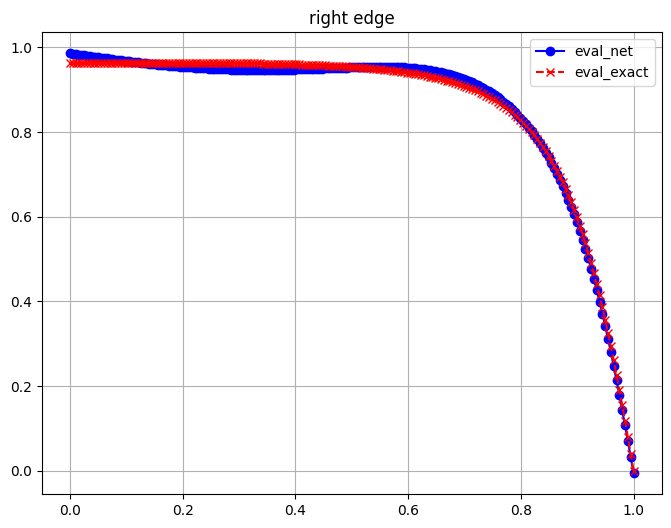

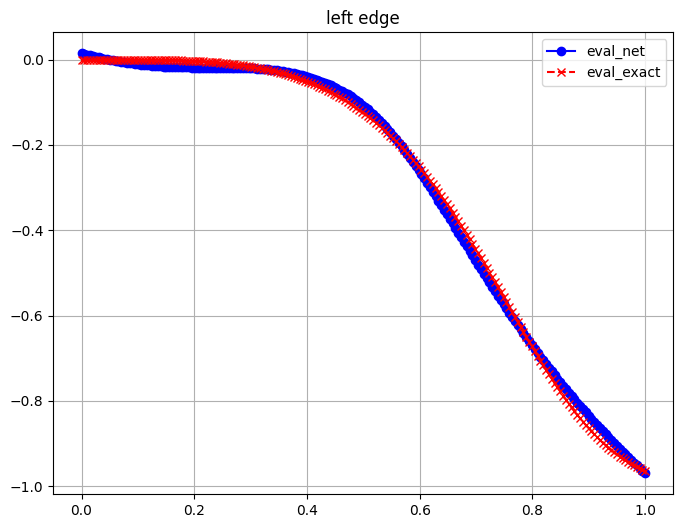

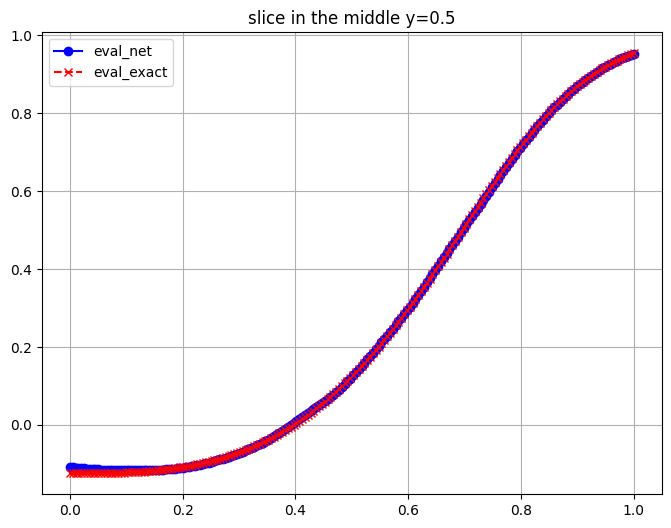

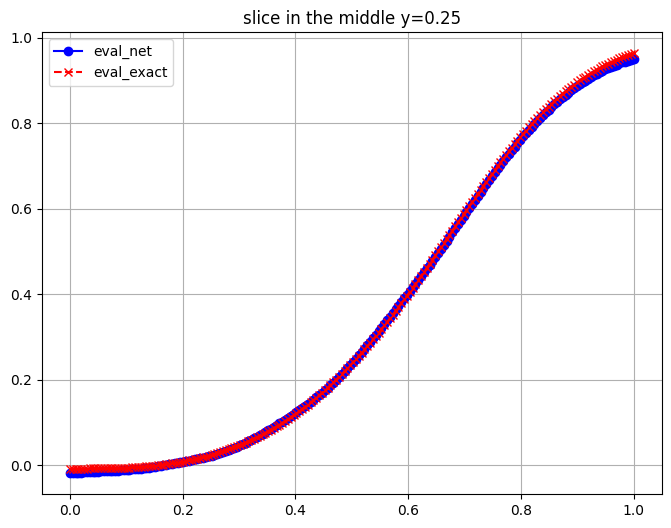

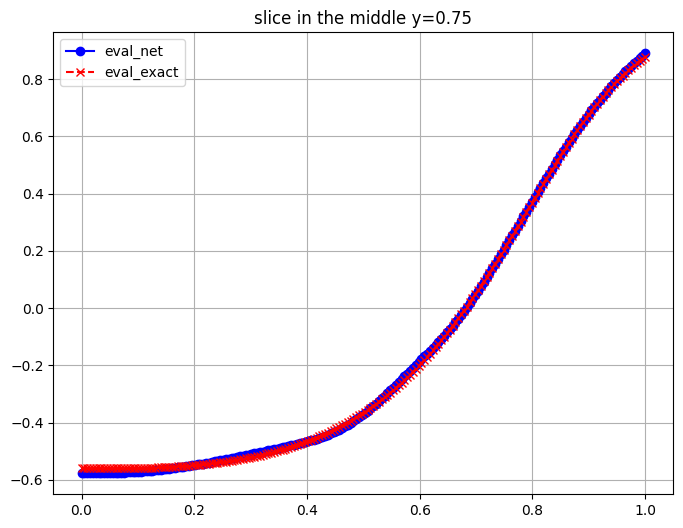

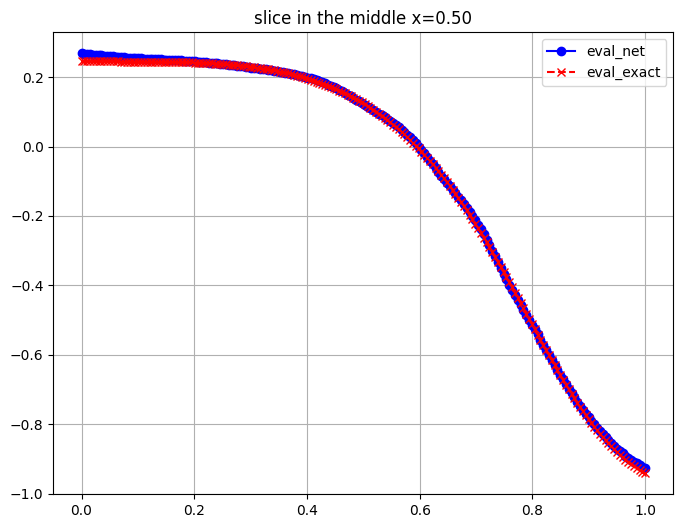

In [20]:
plot_BC(pb.u_exact_np,vp.u_NN_BC)

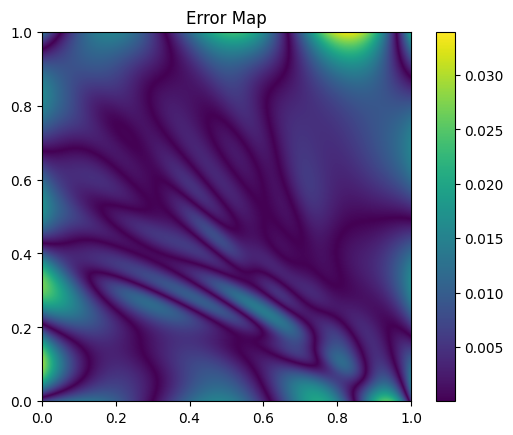

In [21]:
color_plot(vp.NN_imposeBC)

In [22]:
residual_ending_vertices, residual_ending_edges = vp.calc_residuals()

AttributeError: 'VPINN' object has no attribute 'F_total_edges'

In [ ]:
vp.residual_summary(residual_ending_vertices,residual_ending_edges)

residual of vertices : 
-->max  =  6.057158605807292e-05
-->min  =  6.07394944977949e-10
-->mean =  2.642807000636059e-06
residual of edges : 
-->max  =  0.0012784380241886322
-->min  =  5.489096506946203e-10
-->mean =  1.1666660769325533e-05


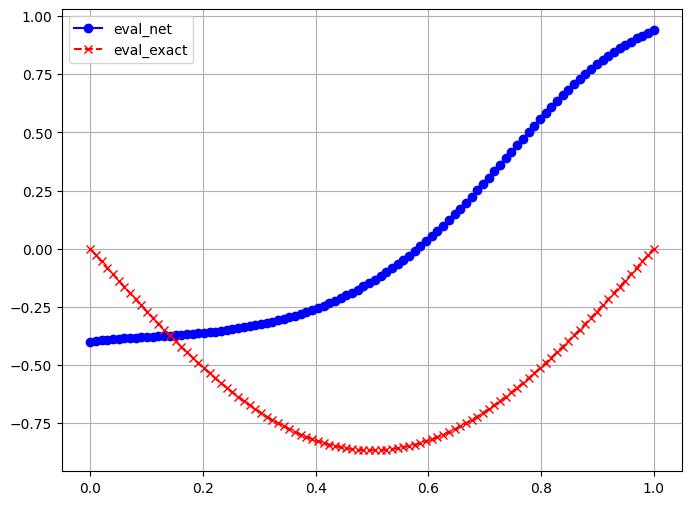

In [ ]:
x=np.linspace(0,1,100,dtype=np.float32)

def u_exact(x,y):

    return np.cos(np.pi*(x+0.5))*np.sin(np.pi*y)


eval_exact=[u_exact(x[i],0.666) for i in range(len(x))]

eval_net=[vp.u_NN_BC(x[i],0.666) for i in range(len(x))]

eval_exact=np.array(eval_exact)
eval_net=np.array(eval_net)



plt.figure(figsize=(8, 6))  # Set the figure size

# Plot the data
plt.plot(x, eval_net, label='eval_net', linestyle='-', marker='o', color='b')
plt.plot(x, eval_exact, label='eval_exact', linestyle='--', marker='x', color='r')
plt.grid()
plt.legend()

In [ ]:
#to just run and see that the net is doing 

history=vp.train(50,0.01)
residual_ending_vertices, residual_ending_edges = vp.calc_residuals()
vp.residual_summary(residual_ending_vertices,residual_ending_edges)




x=np.linspace(0,1,100,dtype=np.float64)
def u_exact(x,y):

    return np.cos(np.pi*(x+0.5))*np.sin(np.pi*y)


eval_exact=[u_exact(x[i],0.666) for i in range(len(x))]

eval_net=[vp.u_NN_BC(x[i],0.666) for i in range(len(x))]

eval_exact=np.array(eval_exact)
eval_net=np.array(eval_net)



plt.figure(figsize=(8, 6))  # Set the figure size

# Plot the data
plt.plot(x, eval_net, label='eval_net', linestyle='-', marker='o', color='b')
plt.plot(x, eval_exact, label='eval_exact', linestyle='--', marker='x', color='r')
plt.grid()
plt.legend()


TypeError: train() missing 1 required positional argument: 'bc_model'

/tmp/ipykernel_13269/3695656763.py:9: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interp2d(x, y, residual_ending_vertices, kind="linear")
/home/mariano/Documenti/test/base/lib/python3.9/site-packages/scipy/interpolate/_fitpack_impl.py:593: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=12,11 m=88 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[

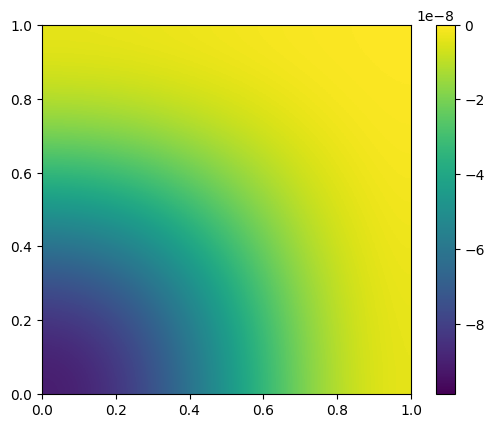

In [ ]:
#print(find_h(mesh)) #biggest and smaller of the edges 
from scipy.interpolate import interp2d
import matplotlib

x = vp.mesh['vertices'][:,0]
y = vp.mesh['vertices'][:,1]


f = interp2d(x, y, residual_ending_vertices, kind="linear")



x_coords = np.arange(min(x), max(x) + 1)
z_coords = np.arange(min(y), max(y) + 1)
c_i = f(x_coords, z_coords)

fig = plt.imshow(
    c_i,
    extent=[min(x), max(x), min(y), max(y)],
    origin="lower",
    interpolation="bicubic",
)

# Show the positions of the sample points, just to have some reference
fig.axes.set_autoscale_on(False)
plt.scatter(x, y, 400, facecolors="none")
plt.colorbar(fig)
plt.show()

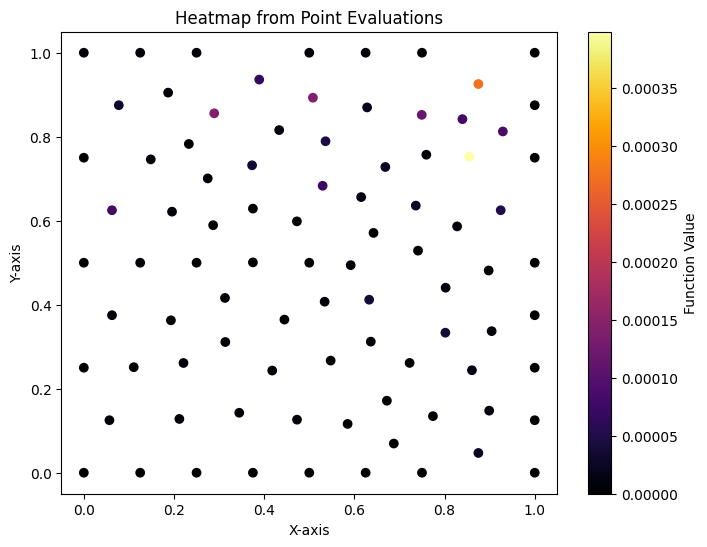

In [ ]:
x = vp.mesh['vertices'][:,0]
y = vp.mesh['vertices'][:,1]



plt.figure(figsize=(8, 6))
# plt.triplot(
#     x,
#     y
# )
scatter = plt.scatter(x, y, c=residual_ending_vertices, cmap='inferno', marker='o')

plt.colorbar(scatter, label='Function Value')
plt.title('Heatmap from Point Evaluations')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [ ]:
f = interp2d(x, y, ending, kind="linear")



x_coords = np.arange(min(x), max(x) + 1)
z_coords = np.arange(min(y), max(y) + 1)
c_i = f(x_coords, z_coords)

fig = plt.imshow(
    c_i,
    extent=[min(x), max(x), min(y), max(y)],
    origin="lower",
    interpolation="bicubic",
)

# Show the positions of the sample points, just to have some reference
fig.axes.set_autoscale_on(False)
plt.scatter(x, y, 400, facecolors="none")
plt.colorbar()
plt.show()

NameError: name 'ending' is not defined

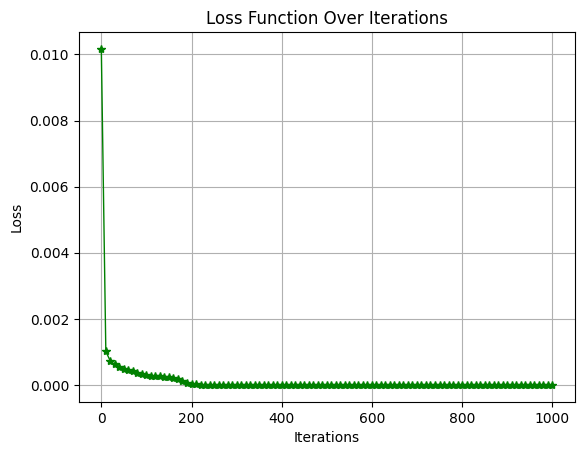

In [ ]:
iterations = range(0, len(history) * 10, 10)  # Assuming losses are provided every 10 iterations

plt.plot(iterations, history, marker='*',color='green',linewidth=1)
plt.title('Loss Function Over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()
plt.show()

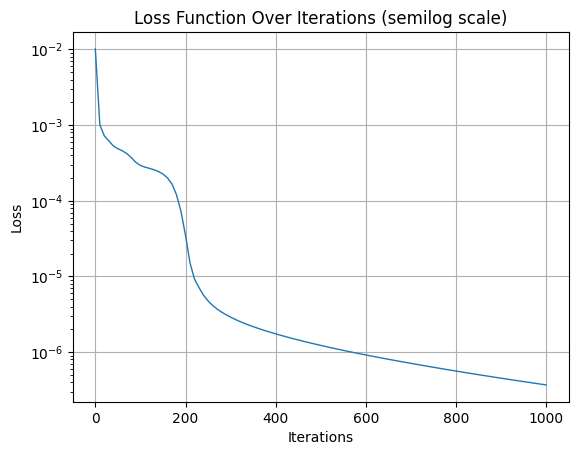

In [ ]:
plt.semilogy(iterations, history,linewidth=1)
plt.title('Loss Function Over Iterations (semilog scale)')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [ ]:
#for the plots 

x=np.linspace(0,1,100,dtype=np.float32)

def u_exact(x,y):

    return np.cos(np.pi*(x+0.5))*np.sin(np.pi*y)


eval_exact=[u_exact(x[i],0.666) for i in range(len(x))]

eval_net=[vp.u_NN_BC(x[i],0.666) for i in range(len(x))]

eval_exact=np.array(eval_exact)
eval_net=np.array(eval_net)



plt.figure(figsize=(8, 6))  # Set the figure size

# Plot the data
plt.plot(x, eval_net, label='eval_net', linestyle='-', marker='o', color='b')
plt.plot(x, eval_exact, label='eval_exact', linestyle='--', marker='x', color='r')
plt.grid()
plt.legend()

In [ ]:
## Add surface plot
N = 50
x=np.linspace(0,1,N,dtype=np.float32)
XX,YY = np.meshgrid(x,x)
xx = XX.flatten()
yy = YY.flatten()

X = np.vstack((xx,yy)).transpose()
Z = [vp.u_NN_BC(x[0],x[1]) for x in X]

z = np.array(Z).flatten().reshape((N,N))

Text(0.5, 0.92, 'NN solution')

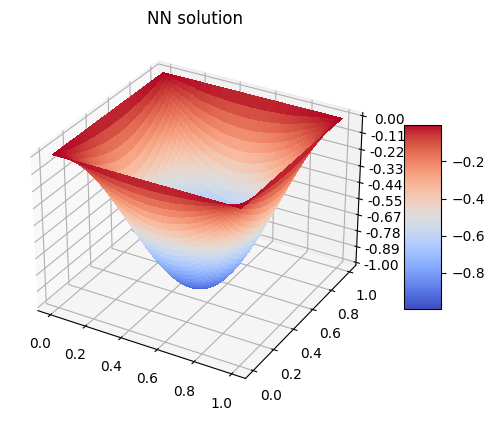

In [ ]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(XX, YY, z, rstride=1, cstride=1, cmap=cm.coolwarm,
    linewidth=0, antialiased=False)
# ax.set_zlim(-1.01, 0)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('NN solution')

In [ ]:
#integration
from scipy.integrate import dblquad
integral,error=dblquad(lambda x,y: (u_exact(x,y)-vp.u_NN_BC(x,y))**2, 0.0, 1.0,0.0, 1.0)

L2_error=np.sqrt(integral)
print(L2_error,error)


def L2_error(x, y):

    u_ex = lambda x, y: tf.cos(np.pi*(x+0.5))*tf.sin(np.pi*y)

    # Find the exact solution
    u_ex = u_ex(x, y)

    # Find the NN solution
    u_NN = vp.u_NN_BC(x, y)

    # Find the difference between exact and NN 
    return (u_ex - u_NN)**2

L2_2, int_error_L2 = dblquad(L2_error, 0.0, 1.0, 0.0, 1.0)
L2_error=np.sqrt(L2_2)

0.0004023303390540288 2.476765626934287e-09


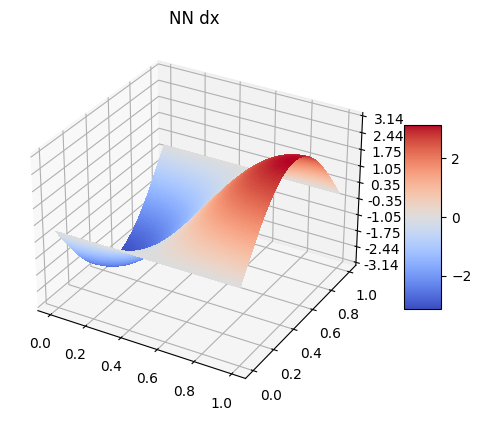

In [ ]:
x = np.linspace(0, 1, 150, dtype=np.float64)
x, y = np.meshgrid(x,x)

u_ex_dx = lambda x, y: -np.pi*tf.sin(np.pi*(x + 0.5))*tf.sin(np.pi*y)
u_ex_dy = lambda x, y: np.pi*tf.cos(np.pi*(x + 0.5))*tf.cos(np.pi*y)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(x, y, u_ex_dx(x,y), rstride=1, cstride=1, cmap=cm.coolwarm,
    linewidth=0, antialiased=False)
# ax.set_zlim(-1.01, 0)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('NN dx')
plt.show()

In [ ]:
def semi_H1_error(x, y):

    u_ex_dx = lambda x, y: -np.pi*tf.sin(np.pi*(x + 0.5))*tf.sin(np.pi*y)
    u_ex_dy = lambda x, y: np.pi*tf.cos(np.pi*(x + 0.5))*tf.cos(np.pi*y)

    # Find the gradient of the exact solution
    grad_ex = np.reshape(np.vstack([u_ex_dx(x, y), u_ex_dy(x, y)]), (-1, 2))

    # Find the gradient of the NN solution
    grad_NN = vp.eval_grad_NN_BC(tf.reshape(tf.stack([x,y]), (-1,2)))

    # Find the difference between exact and NN 
    pw_diff = grad_ex - grad_NN

    # Return dx_error^2 + dy_error^2
    return pw_diff[:,0]*pw_diff[:,0] + pw_diff[:,1]*pw_diff[:,1]

semi_H1_err2, int_error_semi_H1 = dblquad(semi_H1_error, 0.0, 1.0, 0.0, 1.0, epsabs=5E-6)
semi_H1_err = np.sqrt(semi_H1_err2)
H1_err = np.sqrt(L2_error**2 + semi_H1_err**2)

print(f"L2 error: {L2_error} ({int_error_L2})")
print(f"semi H1 error: {semi_H1_err} ({int_error_semi_H1})")
print(f"H1 error: {H1_err}")


L2 error: 0.0004023363610700869 (2.6769474633849205e-09)
semi H1 error: 0.004991998496482129 (6.597307952225612e-08)
H1 error: 0.005008185653140163


basis:
basis function number :  1

1 x^0 y^0 -3 x^1 y^0 2 x^2 y^0 -3 x^0 y^1 4 x^1 y^1 2 x^0 y^2 

basis function number :  2

0 x^0 y^0 4 x^1 y^0 -4 x^2 y^0 0 x^0 y^1 -4 x^1 y^1 0 x^0 y^2 

basis function number :  3

0 x^0 y^0 -1 x^1 y^0 2 x^2 y^0 0 x^0 y^1 0 x^1 y^1 0 x^0 y^2 

basis function number :  4

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 4 x^0 y^1 -4 x^1 y^1 -4 x^0 y^2 

basis function number :  5

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 0 x^0 y^1 4 x^1 y^1 0 x^0 y^2 

basis function number :  6

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 -1 x^0 y^1 0 x^1 y^1 2 x^0 y^2 

basis :
d1x
basis function number :  1

-3 x^0 y^0 4 x^1 y^0 4 x^0 y^1 

d1y
basis function number :  1

-3 x^0 y^0 4 x^1 y^0 4 x^0 y^1 


d1x
basis function number :  2

4 x^0 y^0 -8 x^1 y^0 -4 x^0 y^1 

d1y
basis function number :  2

0 x^0 y^0 -4 x^1 y^0 0 x^0 y^1 


d1x
basis function number :  3

-1 x^0 y^0 4 x^1 y^0 0 x^0 y^1 

d1y
basis function number :  3

0 x^0 y^0 0 x^1 y^0 0 x^0 y^1 


d1x
basis function number :  4

0 x^0 y^0 0 

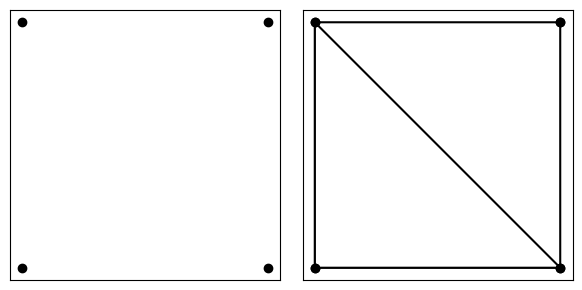

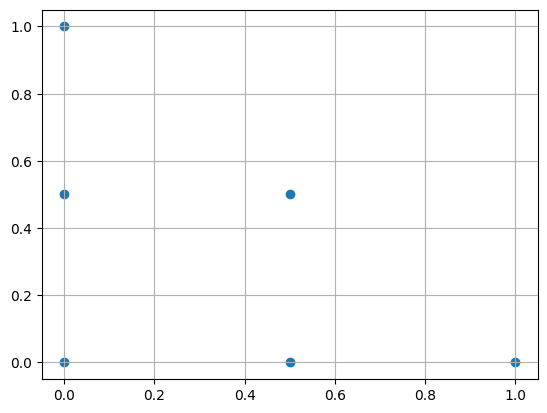

basis:
basis function number :  1

1 x^0 y^0 -3 x^1 y^0 2 x^2 y^0 -3 x^0 y^1 4 x^1 y^1 2 x^0 y^2 

basis function number :  2

0 x^0 y^0 4 x^1 y^0 -4 x^2 y^0 0 x^0 y^1 -4 x^1 y^1 0 x^0 y^2 

basis function number :  3

0 x^0 y^0 -1 x^1 y^0 2 x^2 y^0 0 x^0 y^1 0 x^1 y^1 0 x^0 y^2 

basis function number :  4

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 4 x^0 y^1 -4 x^1 y^1 -4 x^0 y^2 

basis function number :  5

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 0 x^0 y^1 4 x^1 y^1 0 x^0 y^2 

basis function number :  6

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 -1 x^0 y^1 0 x^1 y^1 2 x^0 y^2 

basis :
d1x
basis function number :  1

-3 x^0 y^0 4 x^1 y^0 4 x^0 y^1 

d1y
basis function number :  1

-3 x^0 y^0 4 x^1 y^0 4 x^0 y^1 


d1x
basis function number :  2

4 x^0 y^0 -8 x^1 y^0 -4 x^0 y^1 

d1y
basis function number :  2

0 x^0 y^0 -4 x^1 y^0 0 x^0 y^1 


d1x
basis function number :  3

-1 x^0 y^0 4 x^1 y^0 0 x^0 y^1 

d1y
basis function number :  3

0 x^0 y^0 0 x^1 y^0 0 x^0 y^1 


d1x
basis function number :  4

0 x^0 y^0 0 

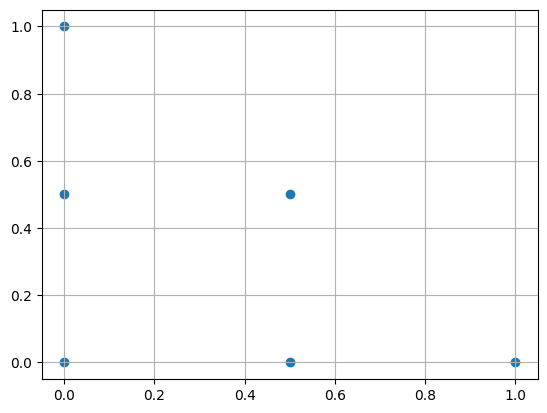

-->mesh : 
     n_triangles :  2
     n_vertices  :  4
     n_edges     :  5
     h_max           :  1.4142135623730951
     h_min           :  1.0
-->test_fun      : 
     order       :  2
     dof         :  1
Iteration: 0 loss: 102.3721624233 time: 0.9978482723236084
Iteration: 10 loss: 44.4887144707 time: 0.009756803512573242
Iteration: 20 loss: 11.0346099579 time: 0.010465383529663086
Iteration: 30 loss: 0.6883418770 time: 0.009124755859375
Iteration: 40 loss: 0.2027919515 time: 0.01006460189819336
Iteration: 50 loss: 0.5127501124 time: 0.010184288024902344
Iteration: 60 loss: 0.2036813099 time: 0.00870823860168457
Iteration: 70 loss: 0.0113568978 time: 0.01012873649597168
Iteration: 80 loss: 0.0068847473 time: 0.008636474609375
Iteration: 90 loss: 0.0102878704 time: 0.010614156723022461
Iteration: 100 loss: 0.0017856742 time: 0.010565519332885742
Iteration: 110 loss: 0.0000646116 time: 0.00838327407836914
Iteration: 120 loss: 0.0004214745 time: 0.01049351692199707
Iteration: 130 

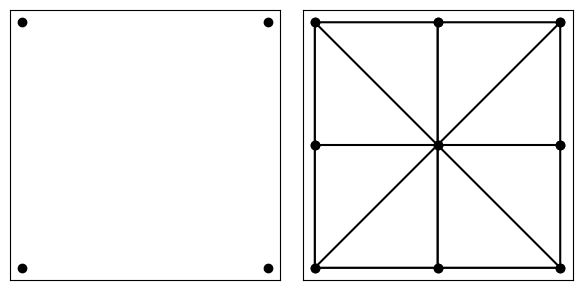

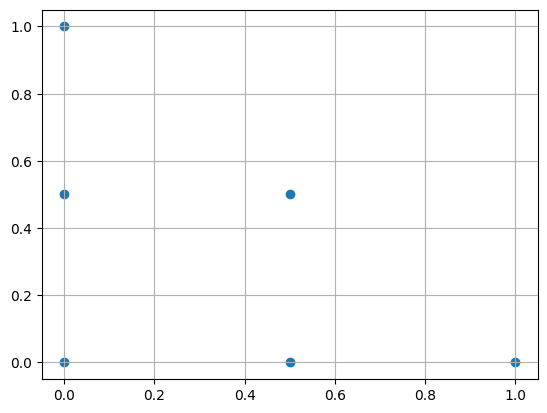

basis:
basis function number :  1

1 x^0 y^0 -3 x^1 y^0 2 x^2 y^0 -3 x^0 y^1 4 x^1 y^1 2 x^0 y^2 

basis function number :  2

0 x^0 y^0 4 x^1 y^0 -4 x^2 y^0 0 x^0 y^1 -4 x^1 y^1 0 x^0 y^2 

basis function number :  3

0 x^0 y^0 -1 x^1 y^0 2 x^2 y^0 0 x^0 y^1 0 x^1 y^1 0 x^0 y^2 

basis function number :  4

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 4 x^0 y^1 -4 x^1 y^1 -4 x^0 y^2 

basis function number :  5

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 0 x^0 y^1 4 x^1 y^1 0 x^0 y^2 

basis function number :  6

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 -1 x^0 y^1 0 x^1 y^1 2 x^0 y^2 

basis :
d1x
basis function number :  1

-3 x^0 y^0 4 x^1 y^0 4 x^0 y^1 

d1y
basis function number :  1

-3 x^0 y^0 4 x^1 y^0 4 x^0 y^1 


d1x
basis function number :  2

4 x^0 y^0 -8 x^1 y^0 -4 x^0 y^1 

d1y
basis function number :  2

0 x^0 y^0 -4 x^1 y^0 0 x^0 y^1 


d1x
basis function number :  3

-1 x^0 y^0 4 x^1 y^0 0 x^0 y^1 

d1y
basis function number :  3

0 x^0 y^0 0 x^1 y^0 0 x^0 y^1 


d1x
basis function number :  4

0 x^0 y^0 0 

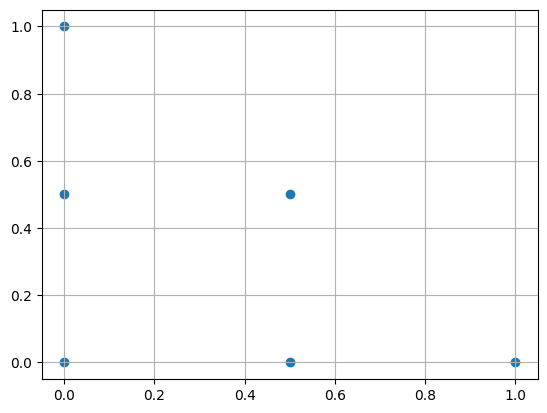

-->mesh : 
     n_triangles :  8
     n_vertices  :  9
     n_edges     :  16
     h_max           :  0.7071067811865476
     h_min           :  0.5
-->test_fun      : 
     order       :  2
     dof         :  9
Iteration: 0 loss: 4.4389883978 time: 1.7354214191436768
Iteration: 10 loss: 2.0172524757 time: 0.015149593353271484
Iteration: 20 loss: 0.6801321067 time: 0.014130353927612305
Iteration: 30 loss: 0.2694131323 time: 0.014528751373291016
Iteration: 40 loss: 0.2228522297 time: 0.014537811279296875
Iteration: 50 loss: 0.1976346182 time: 0.01411294937133789
Iteration: 60 loss: 0.1655511629 time: 0.012570619583129883
Iteration: 70 loss: 0.1489485175 time: 0.01383829116821289
Iteration: 80 loss: 0.1404716194 time: 0.013703584671020508
Iteration: 90 loss: 0.1330109140 time: 0.014332294464111328
Iteration: 100 loss: 0.1268403077 time: 0.014200687408447266
Iteration: 110 loss: 0.1219753557 time: 0.014933347702026367
Iteration: 120 loss: 0.1178765040 time: 0.016337156295776367
Iteration

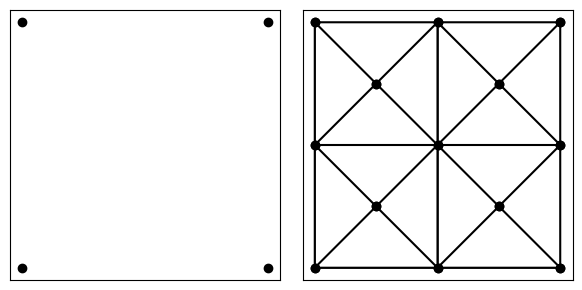

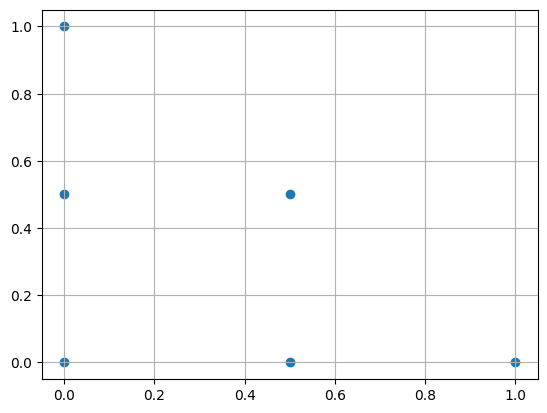

basis:
basis function number :  1

1 x^0 y^0 -3 x^1 y^0 2 x^2 y^0 -3 x^0 y^1 4 x^1 y^1 2 x^0 y^2 

basis function number :  2

0 x^0 y^0 4 x^1 y^0 -4 x^2 y^0 0 x^0 y^1 -4 x^1 y^1 0 x^0 y^2 

basis function number :  3

0 x^0 y^0 -1 x^1 y^0 2 x^2 y^0 0 x^0 y^1 0 x^1 y^1 0 x^0 y^2 

basis function number :  4

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 4 x^0 y^1 -4 x^1 y^1 -4 x^0 y^2 

basis function number :  5

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 0 x^0 y^1 4 x^1 y^1 0 x^0 y^2 

basis function number :  6

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 -1 x^0 y^1 0 x^1 y^1 2 x^0 y^2 

basis :
d1x
basis function number :  1

-3 x^0 y^0 4 x^1 y^0 4 x^0 y^1 

d1y
basis function number :  1

-3 x^0 y^0 4 x^1 y^0 4 x^0 y^1 


d1x
basis function number :  2

4 x^0 y^0 -8 x^1 y^0 -4 x^0 y^1 

d1y
basis function number :  2

0 x^0 y^0 -4 x^1 y^0 0 x^0 y^1 


d1x
basis function number :  3

-1 x^0 y^0 4 x^1 y^0 0 x^0 y^1 

d1y
basis function number :  3

0 x^0 y^0 0 x^1 y^0 0 x^0 y^1 


d1x
basis function number :  4

0 x^0 y^0 0 

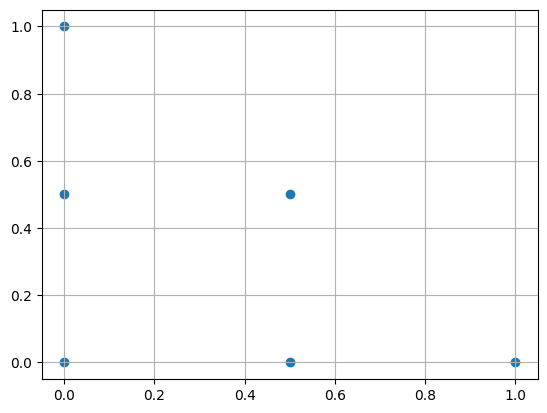

-->mesh : 
     n_triangles :  16
     n_vertices  :  13
     n_edges     :  28
     h_max           :  0.5
     h_min           :  0.3535533905932738
-->test_fun      : 
     order       :  2
     dof         :  25
Iteration: 0 loss: 0.9843306808 time: 2.7827060222625732
Iteration: 10 loss: 0.4528937752 time: 0.019398927688598633
Iteration: 20 loss: 0.1594255125 time: 0.018969297409057617
Iteration: 30 loss: 0.0683094890 time: 0.02029275894165039
Iteration: 40 loss: 0.0567899808 time: 0.01889204978942871
Iteration: 50 loss: 0.0508107954 time: 0.018882274627685547
Iteration: 60 loss: 0.0437788711 time: 0.018691301345825195
Iteration: 70 loss: 0.0401673414 time: 0.018942832946777344
Iteration: 80 loss: 0.0383301085 time: 0.018639326095581055
Iteration: 90 loss: 0.0367341384 time: 0.018976211547851562
Iteration: 100 loss: 0.0354261474 time: 0.0215914249420166
Iteration: 110 loss: 0.0343974447 time: 0.0233767032623291
Iteration: 120 loss: 0.0335288732 time: 0.022554636001586914
Iteration:

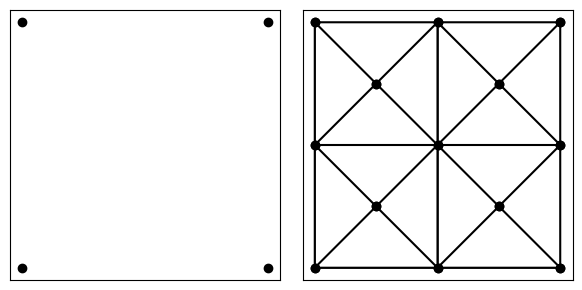

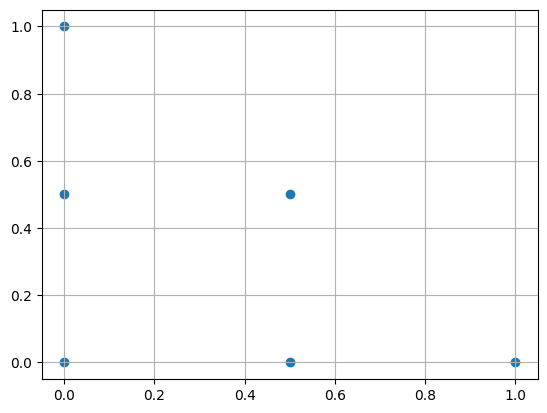

basis:
basis function number :  1

1 x^0 y^0 -3 x^1 y^0 2 x^2 y^0 -3 x^0 y^1 4 x^1 y^1 2 x^0 y^2 

basis function number :  2

0 x^0 y^0 4 x^1 y^0 -4 x^2 y^0 0 x^0 y^1 -4 x^1 y^1 0 x^0 y^2 

basis function number :  3

0 x^0 y^0 -1 x^1 y^0 2 x^2 y^0 0 x^0 y^1 0 x^1 y^1 0 x^0 y^2 

basis function number :  4

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 4 x^0 y^1 -4 x^1 y^1 -4 x^0 y^2 

basis function number :  5

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 0 x^0 y^1 4 x^1 y^1 0 x^0 y^2 

basis function number :  6

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 -1 x^0 y^1 0 x^1 y^1 2 x^0 y^2 

basis :
d1x
basis function number :  1

-3 x^0 y^0 4 x^1 y^0 4 x^0 y^1 

d1y
basis function number :  1

-3 x^0 y^0 4 x^1 y^0 4 x^0 y^1 


d1x
basis function number :  2

4 x^0 y^0 -8 x^1 y^0 -4 x^0 y^1 

d1y
basis function number :  2

0 x^0 y^0 -4 x^1 y^0 0 x^0 y^1 


d1x
basis function number :  3

-1 x^0 y^0 4 x^1 y^0 0 x^0 y^1 

d1y
basis function number :  3

0 x^0 y^0 0 x^1 y^0 0 x^0 y^1 


d1x
basis function number :  4

0 x^0 y^0 0 

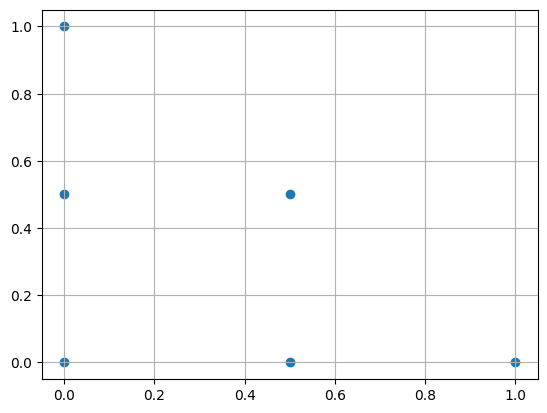

-->mesh : 
     n_triangles :  16
     n_vertices  :  13
     n_edges     :  28
     h_max           :  0.5
     h_min           :  0.3535533905932738
-->test_fun      : 
     order       :  2
     dof         :  25
Iteration: 0 loss: 0.9843306808 time: 3.0840559005737305
Iteration: 10 loss: 0.4528937752 time: 0.020264863967895508
Iteration: 20 loss: 0.1594255125 time: 0.019162893295288086
Iteration: 30 loss: 0.0683094890 time: 0.019178152084350586
Iteration: 40 loss: 0.0567899808 time: 0.0189361572265625
Iteration: 50 loss: 0.0508107954 time: 0.020186185836791992
Iteration: 60 loss: 0.0437788711 time: 0.02028203010559082
Iteration: 70 loss: 0.0401673414 time: 0.018990516662597656
Iteration: 80 loss: 0.0383301085 time: 0.019477128982543945
Iteration: 90 loss: 0.0367341384 time: 0.0190887451171875
Iteration: 100 loss: 0.0354261474 time: 0.01963043212890625
Iteration: 110 loss: 0.0343974447 time: 0.024959325790405273
Iteration: 120 loss: 0.0335288732 time: 0.02277541160583496
Iteration: 

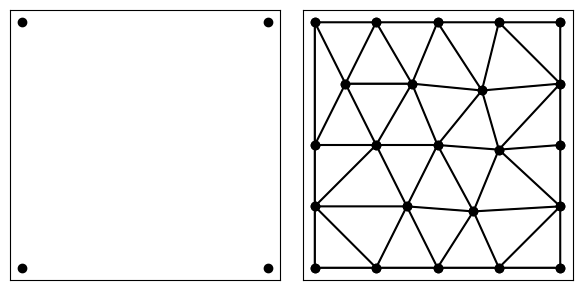

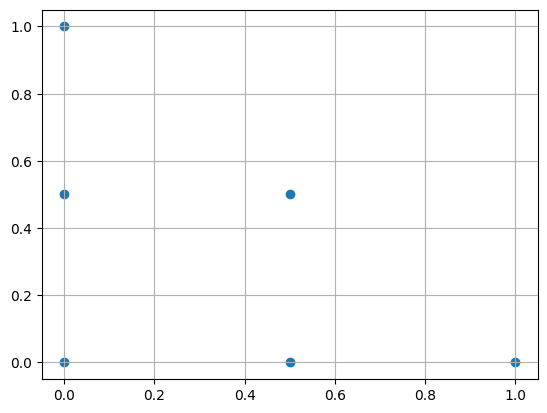

basis:
basis function number :  1

1 x^0 y^0 -3 x^1 y^0 2 x^2 y^0 -3 x^0 y^1 4 x^1 y^1 2 x^0 y^2 

basis function number :  2

0 x^0 y^0 4 x^1 y^0 -4 x^2 y^0 0 x^0 y^1 -4 x^1 y^1 0 x^0 y^2 

basis function number :  3

0 x^0 y^0 -1 x^1 y^0 2 x^2 y^0 0 x^0 y^1 0 x^1 y^1 0 x^0 y^2 

basis function number :  4

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 4 x^0 y^1 -4 x^1 y^1 -4 x^0 y^2 

basis function number :  5

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 0 x^0 y^1 4 x^1 y^1 0 x^0 y^2 

basis function number :  6

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 -1 x^0 y^1 0 x^1 y^1 2 x^0 y^2 

basis :
d1x
basis function number :  1

-3 x^0 y^0 4 x^1 y^0 4 x^0 y^1 

d1y
basis function number :  1

-3 x^0 y^0 4 x^1 y^0 4 x^0 y^1 


d1x
basis function number :  2

4 x^0 y^0 -8 x^1 y^0 -4 x^0 y^1 

d1y
basis function number :  2

0 x^0 y^0 -4 x^1 y^0 0 x^0 y^1 


d1x
basis function number :  3

-1 x^0 y^0 4 x^1 y^0 0 x^0 y^1 

d1y
basis function number :  3

0 x^0 y^0 0 x^1 y^0 0 x^0 y^1 


d1x
basis function number :  4

0 x^0 y^0 0 

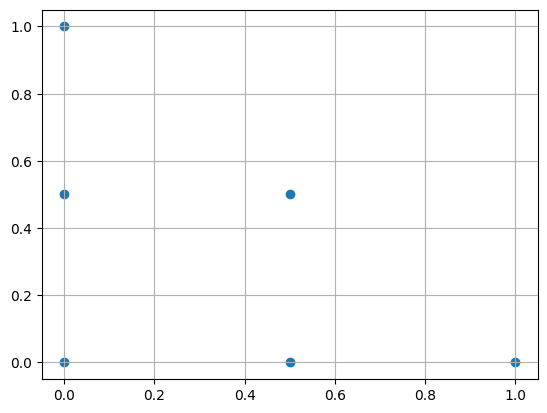

-->mesh : 
     n_triangles :  29
     n_vertices  :  23
     n_edges     :  51
     h_max           :  0.5
     h_min           :  0.25
-->test_fun      : 
     order       :  2
     dof         :  44
Iteration: 0 loss: 0.3203857604 time: 4.943252801895142
Iteration: 10 loss: 0.1489856823 time: 0.030299663543701172
Iteration: 20 loss: 0.0546821400 time: 0.028949260711669922
Iteration: 30 loss: 0.0255859561 time: 0.02795886993408203
Iteration: 40 loss: 0.0216971240 time: 0.029015541076660156
Iteration: 50 loss: 0.0195642123 time: 0.029985904693603516
Iteration: 60 loss: 0.0172533218 time: 0.028778791427612305
Iteration: 70 loss: 0.0160879319 time: 0.028667211532592773
Iteration: 80 loss: 0.0154808048 time: 0.031093358993530273
Iteration: 90 loss: 0.0149540368 time: 0.02982783317565918
Iteration: 100 loss: 0.0145252922 time: 0.03135967254638672
Iteration: 110 loss: 0.0141858421 time: 0.03532838821411133
Iteration: 120 loss: 0.0138969487 time: 0.035375356674194336
Iteration: 130 loss: 0.

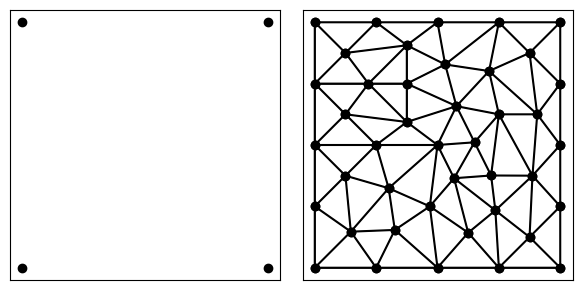

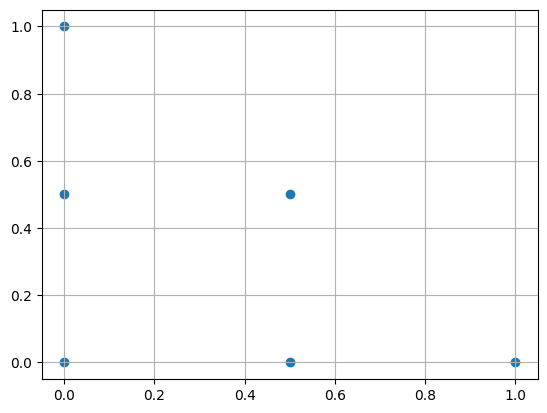

basis:
basis function number :  1

1 x^0 y^0 -3 x^1 y^0 2 x^2 y^0 -3 x^0 y^1 4 x^1 y^1 2 x^0 y^2 

basis function number :  2

0 x^0 y^0 4 x^1 y^0 -4 x^2 y^0 0 x^0 y^1 -4 x^1 y^1 0 x^0 y^2 

basis function number :  3

0 x^0 y^0 -1 x^1 y^0 2 x^2 y^0 0 x^0 y^1 0 x^1 y^1 0 x^0 y^2 

basis function number :  4

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 4 x^0 y^1 -4 x^1 y^1 -4 x^0 y^2 

basis function number :  5

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 0 x^0 y^1 4 x^1 y^1 0 x^0 y^2 

basis function number :  6

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 -1 x^0 y^1 0 x^1 y^1 2 x^0 y^2 

basis :
d1x
basis function number :  1

-3 x^0 y^0 4 x^1 y^0 4 x^0 y^1 

d1y
basis function number :  1

-3 x^0 y^0 4 x^1 y^0 4 x^0 y^1 


d1x
basis function number :  2

4 x^0 y^0 -8 x^1 y^0 -4 x^0 y^1 

d1y
basis function number :  2

0 x^0 y^0 -4 x^1 y^0 0 x^0 y^1 


d1x
basis function number :  3

-1 x^0 y^0 4 x^1 y^0 0 x^0 y^1 

d1y
basis function number :  3

0 x^0 y^0 0 x^1 y^0 0 x^0 y^1 


d1x
basis function number :  4

0 x^0 y^0 0 

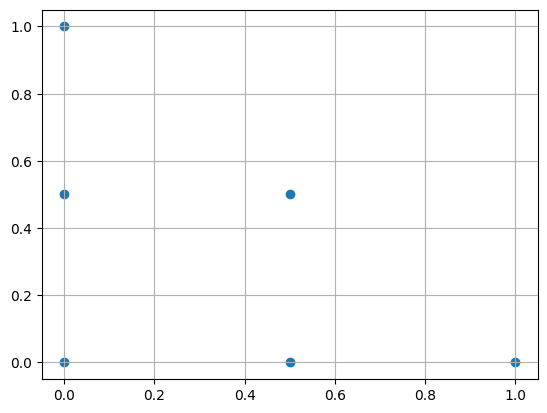

-->mesh : 
     n_triangles :  66
     n_vertices  :  42
     n_edges     :  107
     h_max           :  0.2850357380931555
     h_min           :  0.14330711250516706
-->test_fun      : 
     order       :  2
     dof         :  117
Iteration: 0 loss: 0.0540448724 time: 10.170297384262085
Iteration: 10 loss: 0.0255165640 time: 0.06032609939575195
Iteration: 20 loss: 0.0098428249 time: 0.05758047103881836
Iteration: 30 loss: 0.0049376433 time: 0.05915212631225586
Iteration: 40 loss: 0.0042242410 time: 0.06001925468444824
Iteration: 50 loss: 0.0038524124 time: 0.059351444244384766
Iteration: 60 loss: 0.0034704037 time: 0.06113457679748535
Iteration: 70 loss: 0.0032785065 time: 0.05732560157775879
Iteration: 80 loss: 0.0031756774 time: 0.06267833709716797
Iteration: 90 loss: 0.0030852384 time: 0.06346487998962402
Iteration: 100 loss: 0.0030105764 time: 0.058768272399902344
Iteration: 110 loss: 0.0029494533 time: 0.07541489601135254
Iteration: 120 loss: 0.0028955714 time: 0.07545042037963

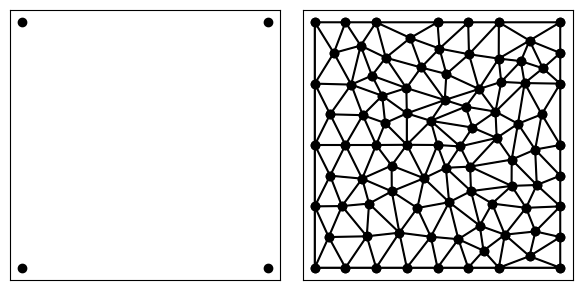

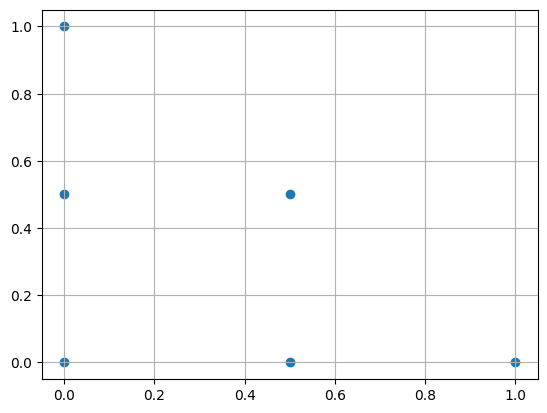

basis:
basis function number :  1

1 x^0 y^0 -3 x^1 y^0 2 x^2 y^0 -3 x^0 y^1 4 x^1 y^1 2 x^0 y^2 

basis function number :  2

0 x^0 y^0 4 x^1 y^0 -4 x^2 y^0 0 x^0 y^1 -4 x^1 y^1 0 x^0 y^2 

basis function number :  3

0 x^0 y^0 -1 x^1 y^0 2 x^2 y^0 0 x^0 y^1 0 x^1 y^1 0 x^0 y^2 

basis function number :  4

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 4 x^0 y^1 -4 x^1 y^1 -4 x^0 y^2 

basis function number :  5

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 0 x^0 y^1 4 x^1 y^1 0 x^0 y^2 

basis function number :  6

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 -1 x^0 y^1 0 x^1 y^1 2 x^0 y^2 

basis :
d1x
basis function number :  1

-3 x^0 y^0 4 x^1 y^0 4 x^0 y^1 

d1y
basis function number :  1

-3 x^0 y^0 4 x^1 y^0 4 x^0 y^1 


d1x
basis function number :  2

4 x^0 y^0 -8 x^1 y^0 -4 x^0 y^1 

d1y
basis function number :  2

0 x^0 y^0 -4 x^1 y^0 0 x^0 y^1 


d1x
basis function number :  3

-1 x^0 y^0 4 x^1 y^0 0 x^0 y^1 

d1y
basis function number :  3

0 x^0 y^0 0 x^1 y^0 0 x^0 y^1 


d1x
basis function number :  4

0 x^0 y^0 0 

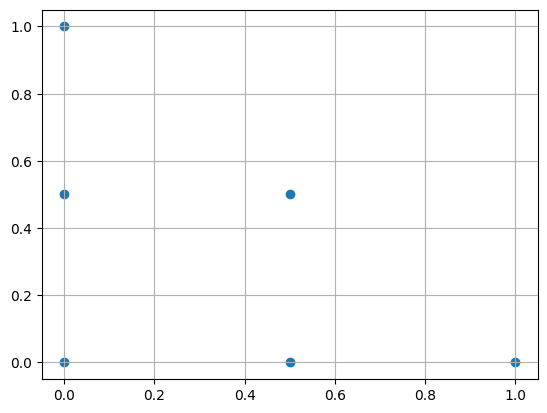

-->mesh : 
     n_triangles :  150
     n_vertices  :  88
     n_edges     :  237
     h_max           :  0.25
     h_min           :  0.0895721626833764
-->test_fun      : 
     order       :  2
     dof         :  277
Iteration: 0 loss: 0.0101664013 time: 24.52495265007019
Iteration: 10 loss: 0.0048388282 time: 0.14742803573608398
Iteration: 20 loss: 0.0018966721 time: 0.14605093002319336
Iteration: 30 loss: 0.0009470426 time: 0.14672017097473145
Iteration: 40 loss: 0.0008016605 time: 0.17583322525024414
Iteration: 50 loss: 0.0007375858 time: 0.17564749717712402
Iteration: 60 loss: 0.0006712132 time: 0.15656661987304688
Iteration: 70 loss: 0.0006383468 time: 0.14742183685302734
Iteration: 80 loss: 0.0006219531 time: 0.14899826049804688
Iteration: 90 loss: 0.0006074836 time: 0.1475505828857422
Iteration: 100 loss: 0.0005953205 time: 0.15245318412780762
Iteration: 110 loss: 0.0005851716 time: 0.16741275787353516
Iteration: 120 loss: 0.0005759297 time: 0.16659927368164062
Iteration: 130

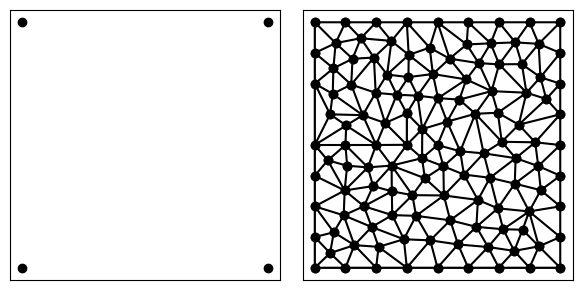

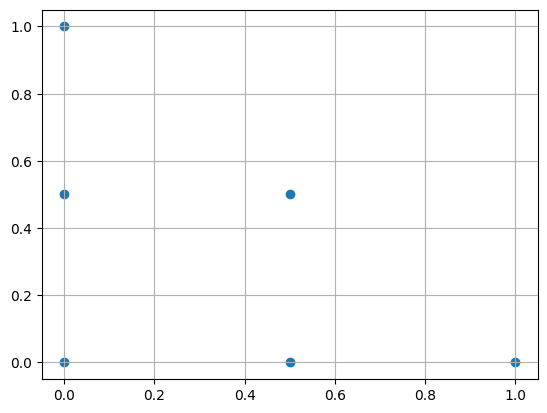

basis:
basis function number :  1

1 x^0 y^0 -3 x^1 y^0 2 x^2 y^0 -3 x^0 y^1 4 x^1 y^1 2 x^0 y^2 

basis function number :  2

0 x^0 y^0 4 x^1 y^0 -4 x^2 y^0 0 x^0 y^1 -4 x^1 y^1 0 x^0 y^2 

basis function number :  3

0 x^0 y^0 -1 x^1 y^0 2 x^2 y^0 0 x^0 y^1 0 x^1 y^1 0 x^0 y^2 

basis function number :  4

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 4 x^0 y^1 -4 x^1 y^1 -4 x^0 y^2 

basis function number :  5

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 0 x^0 y^1 4 x^1 y^1 0 x^0 y^2 

basis function number :  6

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 -1 x^0 y^1 0 x^1 y^1 2 x^0 y^2 

basis :
d1x
basis function number :  1

-3 x^0 y^0 4 x^1 y^0 4 x^0 y^1 

d1y
basis function number :  1

-3 x^0 y^0 4 x^1 y^0 4 x^0 y^1 


d1x
basis function number :  2

4 x^0 y^0 -8 x^1 y^0 -4 x^0 y^1 

d1y
basis function number :  2

0 x^0 y^0 -4 x^1 y^0 0 x^0 y^1 


d1x
basis function number :  3

-1 x^0 y^0 4 x^1 y^0 0 x^0 y^1 

d1y
basis function number :  3

0 x^0 y^0 0 x^1 y^0 0 x^0 y^1 


d1x
basis function number :  4

0 x^0 y^0 0 

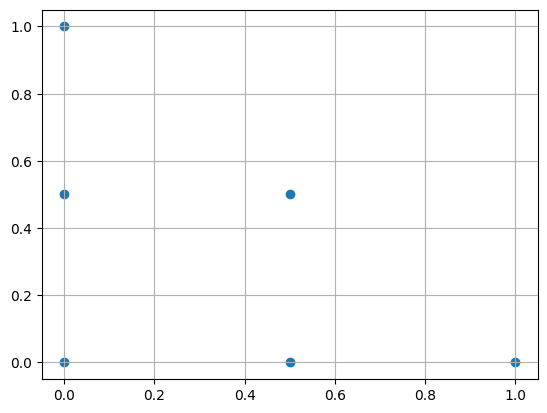

-->mesh : 
     n_triangles :  207
     n_vertices  :  120
     n_edges     :  326
     h_max           :  0.25
     h_min           :  0.07908482369983984
-->test_fun      : 
     order       :  2
     dof         :  384
Iteration: 0 loss: 0.0054580847 time: 33.85343933105469
Iteration: 10 loss: 0.0025611099 time: 0.22068166732788086
Iteration: 20 loss: 0.0009970965 time: 0.21990346908569336
Iteration: 30 loss: 0.0005252049 time: 0.22619009017944336
Iteration: 40 loss: 0.0004536652 time: 0.22219300270080566
Iteration: 50 loss: 0.0004121586 time: 0.22367548942565918
Iteration: 60 loss: 0.0003732784 time: 0.22356343269348145
Iteration: 70 loss: 0.0003545125 time: 0.22155284881591797
Iteration: 80 loss: 0.0003443645 time: 0.22167468070983887
Iteration: 90 loss: 0.0003354979 time: 0.2227928638458252
Iteration: 100 loss: 0.0003282761 time: 0.22905349731445312
Iteration: 110 loss: 0.0003223434 time: 0.24936485290527344
Iteration: 120 loss: 0.0003170591 time: 0.2504911422729492
Iteration: 13

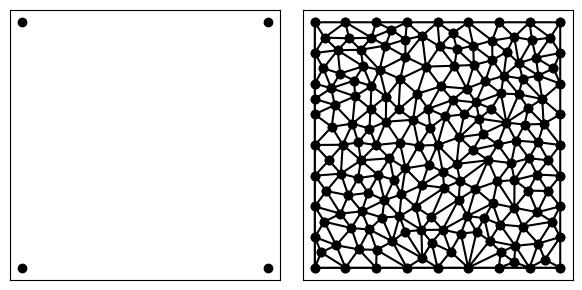

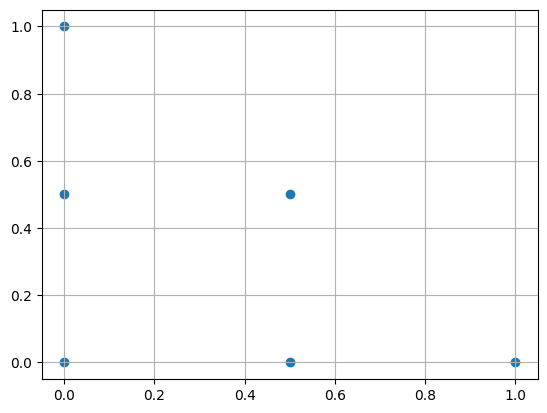

basis:
basis function number :  1

1 x^0 y^0 -3 x^1 y^0 2 x^2 y^0 -3 x^0 y^1 4 x^1 y^1 2 x^0 y^2 

basis function number :  2

0 x^0 y^0 4 x^1 y^0 -4 x^2 y^0 0 x^0 y^1 -4 x^1 y^1 0 x^0 y^2 

basis function number :  3

0 x^0 y^0 -1 x^1 y^0 2 x^2 y^0 0 x^0 y^1 0 x^1 y^1 0 x^0 y^2 

basis function number :  4

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 4 x^0 y^1 -4 x^1 y^1 -4 x^0 y^2 

basis function number :  5

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 0 x^0 y^1 4 x^1 y^1 0 x^0 y^2 

basis function number :  6

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 -1 x^0 y^1 0 x^1 y^1 2 x^0 y^2 

basis :
d1x
basis function number :  1

-3 x^0 y^0 4 x^1 y^0 4 x^0 y^1 

d1y
basis function number :  1

-3 x^0 y^0 4 x^1 y^0 4 x^0 y^1 


d1x
basis function number :  2

4 x^0 y^0 -8 x^1 y^0 -4 x^0 y^1 

d1y
basis function number :  2

0 x^0 y^0 -4 x^1 y^0 0 x^0 y^1 


d1x
basis function number :  3

-1 x^0 y^0 4 x^1 y^0 0 x^0 y^1 

d1y
basis function number :  3

0 x^0 y^0 0 x^1 y^0 0 x^0 y^1 


d1x
basis function number :  4

0 x^0 y^0 0 

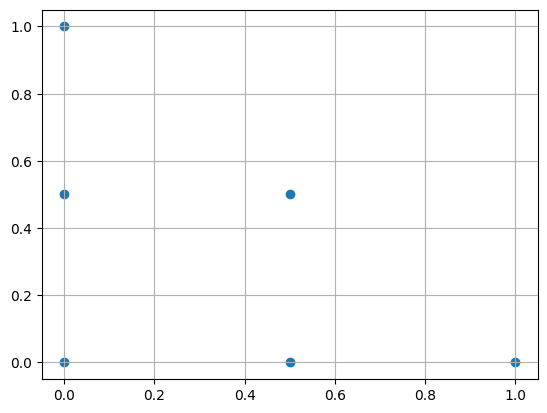

-->mesh : 
     n_triangles :  319
     n_vertices  :  177
     n_edges     :  495
     h_max           :  0.1500397304820275
     h_min           :  0.0625
-->test_fun      : 
     order       :  2
     dof         :  606
Iteration: 0 loss: 0.0023728833 time: 54.744717597961426
Iteration: 10 loss: 0.0011315861 time: 0.4243612289428711
Iteration: 20 loss: 0.0004425612 time: 0.4274444580078125
Iteration: 30 loss: 0.0002217885 time: 0.4097938537597656
Iteration: 40 loss: 0.0001893038 time: 0.41292381286621094
Iteration: 50 loss: 0.0001748407 time: 0.4131162166595459
Iteration: 60 loss: 0.0001592265 time: 0.4146902561187744
Iteration: 70 loss: 0.0001513159 time: 0.4133317470550537
Iteration: 80 loss: 0.0001473834 time: 0.4168212413787842
Iteration: 90 loss: 0.0001439381 time: 0.41645336151123047
Iteration: 100 loss: 0.0001410258 time: 0.4260599613189697
Iteration: 110 loss: 0.0001386040 time: 0.46072840690612793
Iteration: 120 loss: 0.0001364048 time: 0.4652669429779053
Iteration: 130 los

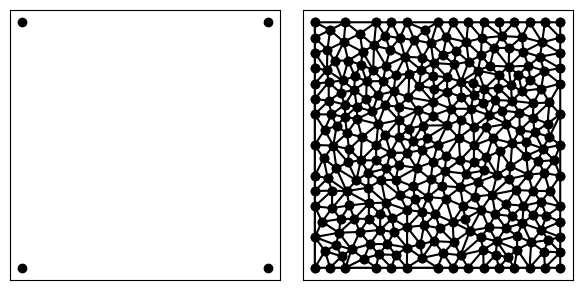

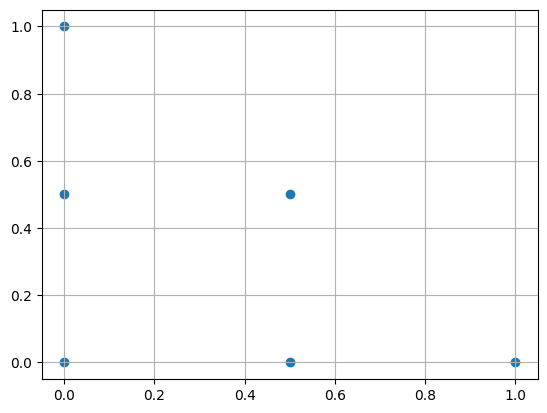

basis:
basis function number :  1

1 x^0 y^0 -3 x^1 y^0 2 x^2 y^0 -3 x^0 y^1 4 x^1 y^1 2 x^0 y^2 

basis function number :  2

0 x^0 y^0 4 x^1 y^0 -4 x^2 y^0 0 x^0 y^1 -4 x^1 y^1 0 x^0 y^2 

basis function number :  3

0 x^0 y^0 -1 x^1 y^0 2 x^2 y^0 0 x^0 y^1 0 x^1 y^1 0 x^0 y^2 

basis function number :  4

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 4 x^0 y^1 -4 x^1 y^1 -4 x^0 y^2 

basis function number :  5

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 0 x^0 y^1 4 x^1 y^1 0 x^0 y^2 

basis function number :  6

0 x^0 y^0 0 x^1 y^0 0 x^2 y^0 -1 x^0 y^1 0 x^1 y^1 2 x^0 y^2 

basis :
d1x
basis function number :  1

-3 x^0 y^0 4 x^1 y^0 4 x^0 y^1 

d1y
basis function number :  1

-3 x^0 y^0 4 x^1 y^0 4 x^0 y^1 


d1x
basis function number :  2

4 x^0 y^0 -8 x^1 y^0 -4 x^0 y^1 

d1y
basis function number :  2

0 x^0 y^0 -4 x^1 y^0 0 x^0 y^1 


d1x
basis function number :  3

-1 x^0 y^0 4 x^1 y^0 0 x^0 y^1 

d1y
basis function number :  3

0 x^0 y^0 0 x^1 y^0 0 x^0 y^1 


d1x
basis function number :  4

0 x^0 y^0 0 

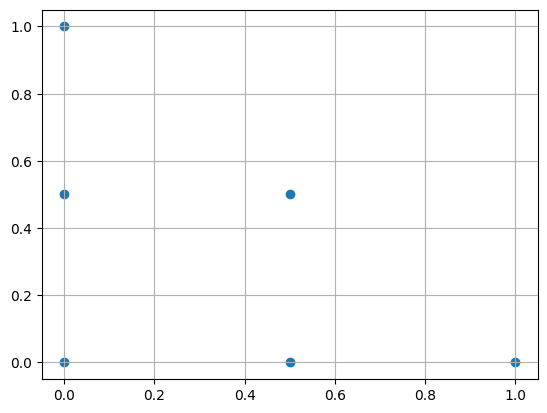

-->mesh : 
     n_triangles :  525
     n_vertices  :  289
     n_edges     :  813
     h_max           :  0.125
     h_min           :  0.04922547486780172
-->test_fun      : 
     order       :  2
     dof         :  1000


KeyboardInterrupt: 

In [ ]:
def restart_model():
    model = tfk.models.Sequential()
    model.add(tf.keras.Input(shape=(2,),dtype=tf.float64))
    model.add(tfkl.Dense(10, activation='tanh',kernel_initializer=initializer,dtype=tf_type,bias_initializer=initializer))
    model.add(tfkl.Dense(10, activation='tanh',kernel_initializer=initializer,dtype=tf_type,bias_initializer=initializer))
    model.add(tfkl.Dense(10, activation='tanh',kernel_initializer=initializer,dtype=tf_type,bias_initializer=initializer))
    model.add(tfkl.Dense(10, activation='tanh',kernel_initializer=initializer,dtype=tf_type,bias_initializer=initializer))
    model.add(tf.keras.layers.Dense(1,activation='linear',kernel_initializer=initializer,dtype=tf_type,use_bias=True))
    return model

H1 = []
L2 = []
semi = []
h = []
for refinement in [0.5, 0.2, 0.1, 0.075, 0.05, 0.025, 0.01, 0.008, 0.005, 0.003]:
    model = restart_model()
    mesh=generate_mesh(domain,refinement)
    vp=VPINN(pb,params,mesh,model)
    history=vp.train(1000, 0.001)

    integral,error=dblquad(lambda x,y: (u_exact(x,y)-vp.u_NN_BC(x,y))**2, 0.0, 1.0,0.0, 1.0)

    L2_error=np.sqrt(integral)

    semi_H1_err2, int_error_semi_H1 = dblquad(semi_H1_error, 0.0, 1.0, 0.0, 1.0, epsabs=5E-6)
    semi_H1_err = np.sqrt(semi_H1_err2)
    H1_err = np.sqrt(L2_error**2 + semi_H1_err**2)

    H1.append(H1_err)
    semi.append(semi_H1_err)
    L2.append(L2_error)
    a, b = find_hs(mesh)
    h.append(0.5*a + 0.5*b)
    
    

In [ ]:
h = np.array(h)

H1 = np.array(H1)
L2 = np.array(L2)
semi = np.array(semi)

H1 rate: 1.2736676487331193
L2 rate: 1.4776942334720964


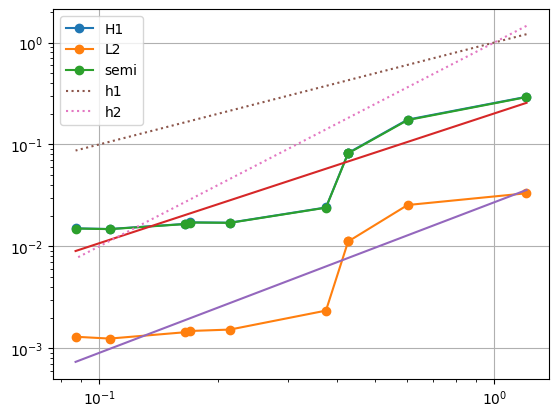

In [ ]:
# slope_H1, intercept_H1 = np.polyfit(h, H1, 1)
# slope_L2, intercept_L2 = np.polyfit(h, L2, 1)

coeffs = np.polyfit(np.log10(h), np.log10(H1), 1)
polynomial = np.poly1d(coeffs)
log10_H1_fit = polynomial(np.log10(h))

print(f"H1 rate: {coeffs[0]}")

coeffs = np.polyfit(np.log10(h), np.log10(L2), 1)
polynomial = np.poly1d(coeffs)
log10_L2_fit = polynomial(np.log10(h))

print(f"L2 rate: {coeffs[0]}")

plt.loglog(h, H1, marker='o', label='H1')
plt.loglog(h, L2, marker='o', label='L2')
plt.loglog(h, semi, marker='o', label='semi')
plt.loglog(h, 10**log10_H1_fit)
plt.loglog(h, 10**log10_L2_fit)
plt.loglog(h, h, linestyle=':', label='h1')
plt.loglog(h, h*h, linestyle=':', label='h2')
plt.grid()
plt.legend()